# 以下テンプレート

In [1]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [2]:
import numpy as np
import datetime
import os
import copy

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"
Label = ['LeftHand','RightHand','LeftLeg','Rightleg','West','Chest']

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"
StorePath = "/media/takeyama/Transfer/02_ActivityResearch/"

if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+'window/'): 
    os.makedirs(StorePath+TITLE+'window/')
WindowDataPath=StorePath+TITLE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+TITLE+DATE+'graph/')
GraphPath=StorePath+TITLE+DATE+'graph/'

**センサデータの読み込み**

In [3]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する．

In [4]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [5]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [14]:
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import regularizers

import matplotlib.image as mpimg


**Phase1 計測データの取得**

ここで行うことは，学習に用いるnpzファイルを読み込む

In [15]:
print DictionaryDataPath

/media/takeyama/Transfer/02_ActivityResearch/Participants01_First_1/dictionary/


In [16]:
DictName=os.listdir(DictionaryDataPath)
print DictName

['Chest.npz', 'LeftHand.npz', 'LeftLeg.npz', 'RightHand.npz', 'Rightleg.npz', 'West.npz']


In [17]:
Sensor1 = np.load(DictionaryDataPath+DictName[0])['data'][()]
Sensor2 = np.load(DictionaryDataPath+DictName[1])['data'][()]
Sensor3 = np.load(DictionaryDataPath+DictName[2])['data'][()]
Sensor4 = np.load(DictionaryDataPath+DictName[3])['data'][()]
Sensor5 = np.load(DictionaryDataPath+DictName[4])['data'][()]
Sensor6 = np.load(DictionaryDataPath+DictName[5])['data'][()]

**Phase2 window flame 作成 & Learning**

In [45]:
def SparseAutoEncoder(TrainWindow,TestWindow,dim,opt,cname,batchSize):
    """
    TrainWindow: 訓練データ
    TestWindow: テストデータ
    dim: 中間層の次元数
    opt: 最適化関数
    cname: 各種データを保存する用の共通の名前
    """
    input_img = Input(shape=( TrainWindow.shape[1],))
    
    encoded = Dense(dim, activation='tanh',\
                W_regularizer=regularizers.WeightRegularizer(l1=10e-5,l2=0.0)\
                   )(input_img)
    decoded = Dense( TrainWindow.shape[1] , activation='linear')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=opt, loss='mse')

    #plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')
    
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    hist = autoencoder.fit(TrainWindow, TrainWindow,
                    nb_epoch=50,
                    verbose=2,
                    batch_size=batchSize,
                    shuffle=False,
                    validation_data=(TestWindow, TestWindow)
                    #callbacks=[early_stopping]
                          )
    time.sleep(0.1)

    encoded_imgs = encoder.predict(TrainWindow,batch_size=batchSize,verbose=1)
    print "encoded_imgs.shape="+str(encoded_imgs.shape)
    decoded_imgs = decoder.predict(encoded_imgs,batch_size=batchSize,verbose=1)

    np.savez(StudyOutputPath+cname+'_Encoded',data=encoded_imgs)
    np.savez(StudyOutputPath+cname+'_Decoded',data=decoded_imgs)

    # save model and wights
    json_string = encoder.to_json()
    open(StudyOutputPath+cname+'_Encoded'+'.json', 'w').write(json_string)
    encoder.save_weights(ParametorPath+cname+'Encode_weights.h5',overwrite=True)

    json_string = decoder.to_json()
    open(StudyOutputPath+cname+'_Decoded'+'.json', 'w').write(json_string)
    decoder.save_weights(ParametorPath+cname+'Decord_weights.h5',overwrite=True)

    json_string = autoencoder.to_json()
    open(StudyOutputPath+cname+'_Net'+'.json', 'w').write(json_string)
    autoencoder.save_weights(ParametorPath+cname+'Net_weights.h5',overwrite=True)

    # plot loss
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    nb_epoch = len(loss)
    plt.plot(range(nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(ResultPath+cname+'.png')
    plt.show()

In [46]:
def GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH):
    """
    data　ウィンドウフレームに変換するデータ
    registName　ウィンドウフレームに登録するデータの名前
    windowWidth　ウィンドウ幅
    slidingWidth　スライド幅
    PATH ウィドウフレームを保存するディレクトリ
    
    
    About Function:
        与えられたdataからウィンドウ幅windowWidth,スライド幅slidingWidthにしたがって
        registNameのウィドウフレームを返す．
        また，与えれたPATH内に同様なパラメータ( WindowWidth, slidingWidth)かつ同様な
        windowNameのものがある場合，そのデータを返す．
        この関数が登録，ウィンドウフレームに変換できるデータは１つとする
    """
    storedName = windowName+'_Win='+str(wWidth).zfill(4)+'_Sld='+str(sWidth).zfill(4)+'.npz'
    l = os.listdir(PATH)
    
    if storedName in l:
        print "this data had finished making"
        return np.load(PATH+storedName)['data'][()]
    
    w=window()
    w.SetData(windowName,dataRaw)    
    wind=w.Compile(wWidth,sWidth)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))
    
    np.savez(PATH+storedName,data=wind)

    return wind

In [47]:
GetWindowFrame('AccX',Sensor1['AccX'],256,256/8,WindowDataPath)

this data had finished making


array([[ 0.8825,  0.8755,  0.8711, ...,  0.9233,  0.925 ,  0.9206],
       [ 0.8674,  0.8728,  0.8821, ...,  0.8264,  0.824 ,  0.8271],
       [ 0.8371,  0.8437,  0.8447, ...,  0.8532,  0.8471,  0.8498],
       ..., 
       [-0.1003, -0.0998, -0.0912, ..., -0.0995, -0.0942, -0.0925],
       [-0.1   , -0.1025, -0.1022, ..., -0.0939, -0.0986, -0.0966],
       [-0.0939, -0.0978, -0.0981, ..., -0.0976, -0.1015, -0.0973]])

# スクリプトの目的
本スクリプトの目的および学習方法を明記する
目的：
スパースAEによる学習
また，コピー元である"Keras-Participants01-Sensor1-AccX"にスパースを加えた変化を見る

変更点:
* 学習はSparseAutoEncoder関数で行う
* CommonNameの最後にSparseを付ける

パラメータ
コピー元と同様

this data had finished making
_AEdim=016_Win=0256_Sld=0032_Adam_Sparse
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0270 - val_loss: 0.0308
Epoch 2/50
1s - loss: 0.0094 - val_loss: 0.0159
Epoch 3/50
1s - loss: 0.0077 - val_loss: 0.0079
Epoch 4/50
1s - loss: 0.0068 - val_loss: 0.0053
Epoch 5/50
1s - loss: 0.0059 - val_loss: 0.0061
Epoch 6/50
1s - loss: 0.0053 - val_loss: 0.0046
Epoch 7/50
1s - loss: 0.0049 - val_loss: 0.0109
Epoch 8/50
1s - loss: 0.0047 - val_loss: 0.0154
Epoch 9/50
1s - loss: 0.0045 - val_loss: 0.0153
Epoch 10/50
1s - loss: 0.0043 - val_loss: 0.0132
Epoch 11/50
1s - loss: 0.0042 - val_loss: 0.0165
Epoch 12/50
1s - loss: 0.0041 - val_loss: 0.0131
Epoch 13/50
1s - loss: 0.0041 - val_loss: 0.0100
Epoch 14/50
1s - loss: 0.0039 - val_loss: 0.0106
Epoch 15/50
1s - loss: 0.0041 - val_loss: 0.0074
Epoch 16/50
1s - loss: 0.0038 - val_loss: 0.0072
Epoch 17/50
1s - loss: 0.0038 - val_loss: 0.0060
Epoch 18/50
1s - loss: 0.0038 - val_loss: 0.0070
Epoch 

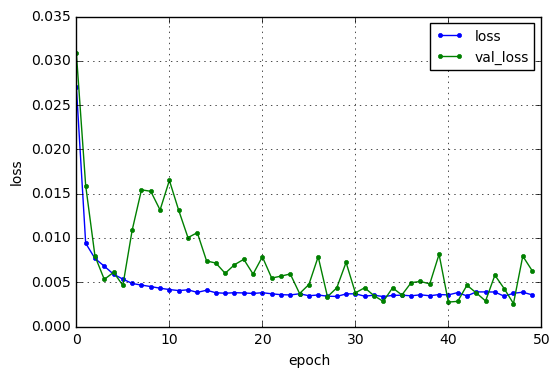

this data had finished making
_AEdim=016_Win=0512_Sld=0064_Adam_Sparse
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.0411 - val_loss: 0.0480
Epoch 2/50
0s - loss: 0.0142 - val_loss: 0.0323
Epoch 3/50
0s - loss: 0.0122 - val_loss: 0.0331
Epoch 4/50
0s - loss: 0.0117 - val_loss: 0.0324
Epoch 5/50
0s - loss: 0.0110 - val_loss: 0.0318
Epoch 6/50
0s - loss: 0.0105 - val_loss: 0.0289
Epoch 7/50
0s - loss: 0.0104 - val_loss: 0.0289
Epoch 8/50
0s - loss: 0.0096 - val_loss: 0.0230
Epoch 9/50
0s - loss: 0.0091 - val_loss: 0.0232
Epoch 10/50
0s - loss: 0.0093 - val_loss: 0.0209
Epoch 11/50
0s - loss: 0.0088 - val_loss: 0.0215
Epoch 12/50
0s - loss: 0.0087 - val_loss: 0.0216
Epoch 13/50
0s - loss: 0.0077 - val_loss: 0.0196
Epoch 14/50
0s - loss: 0.0080 - val_loss: 0.0187
Epoch 15/50
0s - loss: 0.0084 - val_loss: 0.0213
Epoch 16/50
0s - loss: 0.0091 - val_loss: 0.0334
Epoch 17/50
0s - loss: 0.0101 - val_loss: 0.0327
Epoch 18/50
0s - loss: 0.0089 - val_loss: 0.0249
Epoch 

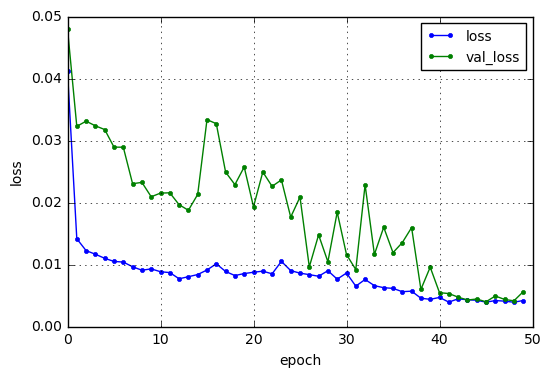

this data had finished making
_AEdim=016_Win=1024_Sld=0128_Adam_Sparse
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0615 - val_loss: 0.0302
Epoch 2/50
0s - loss: 0.0359 - val_loss: 0.0278
Epoch 3/50
0s - loss: 0.0379 - val_loss: 0.0459
Epoch 4/50
0s - loss: 0.0358 - val_loss: 0.0262
Epoch 5/50
0s - loss: 0.0364 - val_loss: 0.0273
Epoch 6/50
0s - loss: 0.0402 - val_loss: 0.0485
Epoch 7/50
0s - loss: 0.0353 - val_loss: 0.0270
Epoch 8/50
0s - loss: 0.0358 - val_loss: 0.0409
Epoch 9/50
0s - loss: 0.0343 - val_loss: 0.0237
Epoch 10/50
0s - loss: 0.0430 - val_loss: 0.0352
Epoch 11/50
0s - loss: 0.0484 - val_loss: 0.0606
Epoch 12/50
0s - loss: 0.0435 - val_loss: 0.0587
Epoch 13/50
0s - loss: 0.0376 - val_loss: 0.0454
Epoch 14/50
0s - loss: 0.0341 - val_loss: 0.0459
Epoch 15/50
0s - loss: 0.0353 - val_loss: 0.0461
Epoch 16/50
0s - loss: 0.0325 - val_loss: 0.0260
Epoch 17/50
0s - loss: 0.0363 - val_loss: 0.0538
Epoch 18/50
0s - loss: 0.0429 - val_loss: 0.0225
Epoch 19

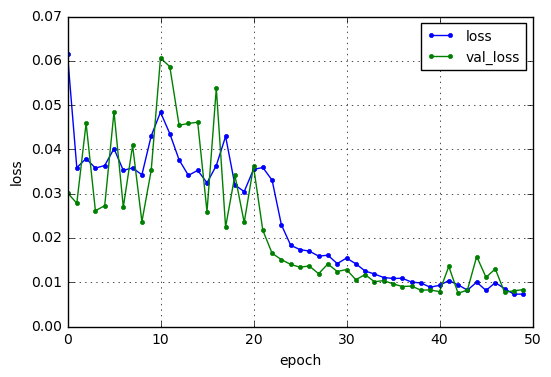

this data had finished making
_AEdim=016_Win=2048_Sld=0256_Adam_Sparse
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0892 - val_loss: 0.0563
Epoch 2/50
0s - loss: 0.0461 - val_loss: 0.0434
Epoch 3/50
0s - loss: 0.0482 - val_loss: 0.0422
Epoch 4/50
0s - loss: 0.0474 - val_loss: 0.0366
Epoch 5/50
0s - loss: 0.0616 - val_loss: 0.0516
Epoch 6/50
0s - loss: 0.0607 - val_loss: 0.0553
Epoch 7/50
0s - loss: 0.0582 - val_loss: 0.0580
Epoch 8/50
0s - loss: 0.0640 - val_loss: 0.0680
Epoch 9/50
0s - loss: 0.0693 - val_loss: 0.0373
Epoch 10/50
0s - loss: 0.0495 - val_loss: 0.0365
Epoch 11/50
0s - loss: 0.0688 - val_loss: 0.0696
Epoch 12/50
0s - loss: 0.0557 - val_loss: 0.0618
Epoch 13/50
0s - loss: 0.0625 - val_loss: 0.0610
Epoch 14/50
0s - loss: 0.0517 - val_loss: 0.0493
Epoch 15/50
0s - loss: 0.0477 - val_loss: 0.0552
Epoch 16/50
0s - loss: 0.0676 - val_loss: 0.0687
Epoch 17/50
0s - loss: 0.0581 - val_loss: 0.0709
Epoch 18/50
0s - loss: 0.0571 - val_loss: 0.0684
Epoch 19

KeyboardInterrupt: 

In [48]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='Adam'
AEDimention = 16

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
        '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+'_Sparse'
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    SparseAutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

学習の過程を見ると，明らかにおかしな学習をしていることがわかる．これの原因としてを列挙する
* 学習の際に入力データをシャッフルせず，時系列順に渡しているから
* 最適化方法が合ってない
* バッチサイズが最適値でない  
他にも原因あるが，とりあえず一番の内容はもう少し考える．
まずは，最適化方法を試す．

this data had finished making
hiden node = 16
_AEdim=016_Win=0256_Sld=0032_rmsprop_Sparse
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0174 - val_loss: 0.0095
Epoch 2/50
1s - loss: 0.0058 - val_loss: 0.0088
Epoch 3/50
1s - loss: 0.0053 - val_loss: 0.0085
Epoch 4/50
1s - loss: 0.0050 - val_loss: 0.0085
Epoch 5/50
1s - loss: 0.0048 - val_loss: 0.0086
Epoch 6/50
1s - loss: 0.0046 - val_loss: 0.0086
Epoch 7/50
1s - loss: 0.0045 - val_loss: 0.0086
Epoch 8/50
1s - loss: 0.0044 - val_loss: 0.0087
Epoch 9/50
1s - loss: 0.0044 - val_loss: 0.0087
Epoch 10/50
1s - loss: 0.0043 - val_loss: 0.0086
Epoch 11/50
1s - loss: 0.0042 - val_loss: 0.0085
Epoch 12/50
1s - loss: 0.0042 - val_loss: 0.0085
Epoch 13/50
1s - loss: 0.0041 - val_loss: 0.0085
Epoch 14/50
1s - loss: 0.0041 - val_loss: 0.0086
Epoch 15/50
1s - loss: 0.0041 - val_loss: 0.0084
Epoch 16/50
1s - loss: 0.0040 - val_loss: 0.0085
Epoch 17/50
1s - loss: 0.0040 - val_loss: 0.0083
Epoch 18/50
1s - loss: 0.0040 - val_

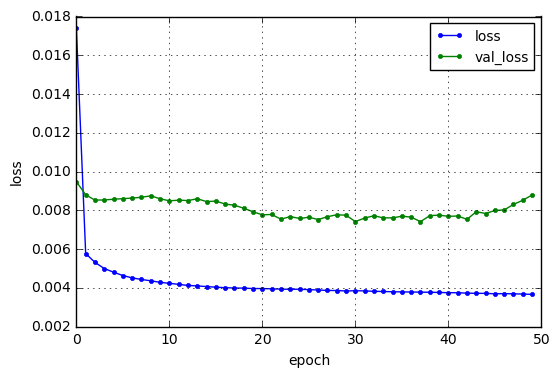

this data had finished making
hiden node = 16
_AEdim=016_Win=0512_Sld=0064_rmsprop_Sparse
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.0296 - val_loss: 0.0115
Epoch 2/50
1s - loss: 0.0098 - val_loss: 0.0110
Epoch 3/50
1s - loss: 0.0093 - val_loss: 0.0117
Epoch 4/50
1s - loss: 0.0089 - val_loss: 0.0119
Epoch 5/50
1s - loss: 0.0086 - val_loss: 0.0122
Epoch 6/50
1s - loss: 0.0083 - val_loss: 0.0122
Epoch 7/50
1s - loss: 0.0081 - val_loss: 0.0121
Epoch 8/50
1s - loss: 0.0079 - val_loss: 0.0115
Epoch 9/50
1s - loss: 0.0078 - val_loss: 0.0107
Epoch 10/50
1s - loss: 0.0076 - val_loss: 0.0104
Epoch 11/50
1s - loss: 0.0075 - val_loss: 0.0106
Epoch 12/50
1s - loss: 0.0073 - val_loss: 0.0104
Epoch 13/50
1s - loss: 0.0072 - val_loss: 0.0107
Epoch 14/50
1s - loss: 0.0072 - val_loss: 0.0105
Epoch 15/50
1s - loss: 0.0071 - val_loss: 0.0110
Epoch 16/50
1s - loss: 0.0070 - val_loss: 0.0112
Epoch 17/50
1s - loss: 0.0070 - val_loss: 0.0114
Epoch 18/50
1s - loss: 0.0069 - val_

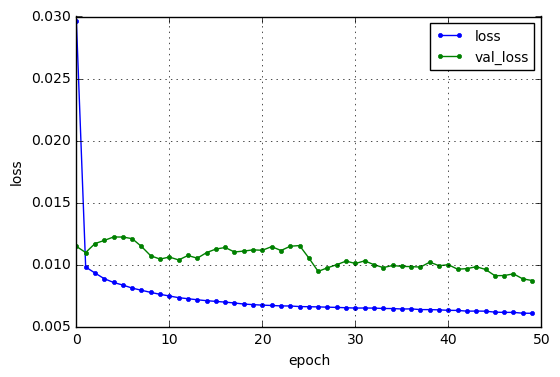

this data had finished making
hiden node = 16
_AEdim=016_Win=1024_Sld=0128_rmsprop_Sparse
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0506 - val_loss: 0.0199
Epoch 2/50
0s - loss: 0.0176 - val_loss: 0.0173
Epoch 3/50
0s - loss: 0.0165 - val_loss: 0.0162
Epoch 4/50
0s - loss: 0.0157 - val_loss: 0.0136
Epoch 5/50
0s - loss: 0.0154 - val_loss: 0.0134
Epoch 6/50
0s - loss: 0.0152 - val_loss: 0.0150
Epoch 7/50
0s - loss: 0.0150 - val_loss: 0.0155
Epoch 8/50
0s - loss: 0.0146 - val_loss: 0.0154
Epoch 9/50
0s - loss: 0.0144 - val_loss: 0.0148
Epoch 10/50
0s - loss: 0.0141 - val_loss: 0.0143
Epoch 11/50
0s - loss: 0.0138 - val_loss: 0.0139
Epoch 12/50
0s - loss: 0.0138 - val_loss: 0.0130
Epoch 13/50
0s - loss: 0.0136 - val_loss: 0.0126
Epoch 14/50
0s - loss: 0.0135 - val_loss: 0.0122
Epoch 15/50
0s - loss: 0.0133 - val_loss: 0.0122
Epoch 16/50
0s - loss: 0.0131 - val_loss: 0.0127
Epoch 17/50
0s - loss: 0.0131 - val_loss: 0.0128
Epoch 18/50
0s - loss: 0.0130 - val_lo

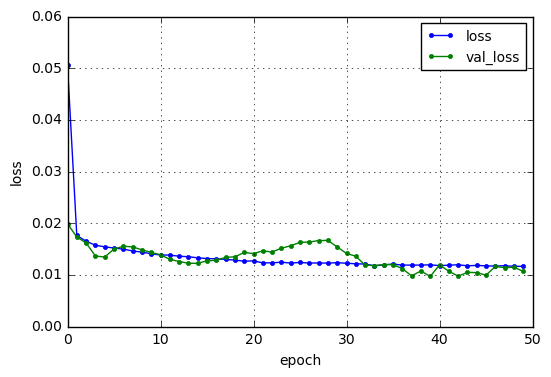

this data had finished making
hiden node = 16
_AEdim=016_Win=2048_Sld=0256_rmsprop_Sparse
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0716 - val_loss: 0.0379
Epoch 2/50
0s - loss: 0.0340 - val_loss: 0.0289
Epoch 3/50
0s - loss: 0.0283 - val_loss: 0.0280
Epoch 4/50
0s - loss: 0.0297 - val_loss: 0.0233
Epoch 5/50
0s - loss: 0.0270 - val_loss: 0.0284
Epoch 6/50
0s - loss: 0.0269 - val_loss: 0.0250
Epoch 7/50
0s - loss: 0.0291 - val_loss: 0.0270
Epoch 8/50
0s - loss: 0.0300 - val_loss: 0.0192
Epoch 9/50
0s - loss: 0.0256 - val_loss: 0.0199
Epoch 10/50
0s - loss: 0.0275 - val_loss: 0.0305
Epoch 11/50
0s - loss: 0.0307 - val_loss: 0.0202
Epoch 12/50
0s - loss: 0.0316 - val_loss: 0.0243
Epoch 13/50
0s - loss: 0.0264 - val_loss: 0.0218
Epoch 14/50
0s - loss: 0.0285 - val_loss: 0.0183
Epoch 15/50
0s - loss: 0.0290 - val_loss: 0.0210
Epoch 16/50
0s - loss: 0.0286 - val_loss: 0.0212
Epoch 17/50
0s - loss: 0.0281 - val_loss: 0.0190
Epoch 18/50
0s - loss: 0.0259 - val_lo

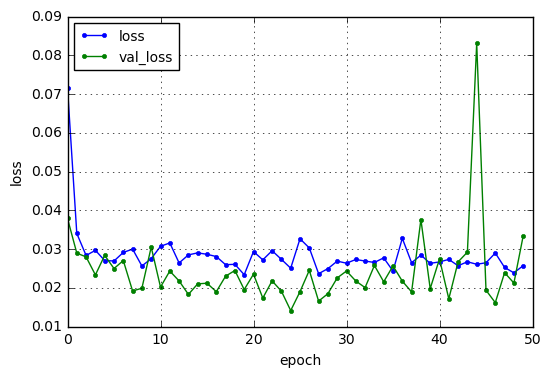

this data had finished making
hiden node = 16
_AEdim=016_Win=4096_Sld=0512_rmsprop_Sparse
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.1085 - val_loss: 0.0681
Epoch 2/50
0s - loss: 0.0584 - val_loss: 0.0854
Epoch 3/50
0s - loss: 0.0482 - val_loss: 0.0586
Epoch 4/50
0s - loss: 0.0549 - val_loss: 0.0490
Epoch 5/50
0s - loss: 0.0446 - val_loss: 0.0888
Epoch 6/50
0s - loss: 0.0451 - val_loss: 0.0818
Epoch 7/50
0s - loss: 0.0454 - val_loss: 0.0504
Epoch 8/50
0s - loss: 0.0492 - val_loss: 0.0509
Epoch 9/50
0s - loss: 0.0489 - val_loss: 0.0436
Epoch 10/50
0s - loss: 0.0414 - val_loss: 0.0474
Epoch 11/50
0s - loss: 0.0475 - val_loss: 0.0583
Epoch 12/50
0s - loss: 0.0497 - val_loss: 0.0516
Epoch 13/50
0s - loss: 0.0516 - val_loss: 0.0562
Epoch 14/50
0s - loss: 0.0436 - val_loss: 0.0493
Epoch 15/50
0s - loss: 0.0402 - val_loss: 0.0625
Epoch 16/50
0s - loss: 0.0440 - val_loss: 0.0514
Epoch 17/50
0s - loss: 0.0381 - val_loss: 0.0539
Epoch 18/50
0s - loss: 0.0424 - val_lo

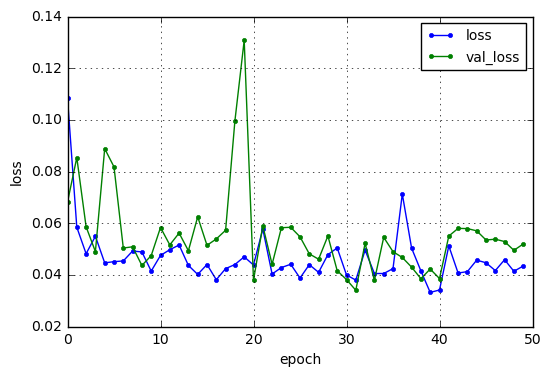

In [39]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='rmsprop'
AEDimention = 16

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+'_Sparse'
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    SparseAutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

バッチサイズを変更してみる，まずは試しに先ほどの半分で学習する

this data had finished making
hiden node = 16
_dim=16_Win=0256_Sld=0032_rmsprop_Sparse
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.0127 - val_loss: 0.0077
Epoch 2/50
3s - loss: 0.0049 - val_loss: 0.0070
Epoch 3/50
3s - loss: 0.0045 - val_loss: 0.0072
Epoch 4/50
3s - loss: 0.0043 - val_loss: 0.0075
Epoch 5/50
3s - loss: 0.0042 - val_loss: 0.0077
Epoch 6/50
2s - loss: 0.0041 - val_loss: 0.0092
Epoch 7/50
2s - loss: 0.0040 - val_loss: 0.0096
Epoch 8/50
2s - loss: 0.0039 - val_loss: 0.0090
Epoch 9/50
2s - loss: 0.0039 - val_loss: 0.0084
Epoch 10/50
2s - loss: 0.0038 - val_loss: 0.0079
Epoch 11/50
2s - loss: 0.0038 - val_loss: 0.0079
Epoch 12/50
2s - loss: 0.0038 - val_loss: 0.0080
Epoch 13/50
2s - loss: 0.0038 - val_loss: 0.0081
Epoch 14/50
2s - loss: 0.0037 - val_loss: 0.0082
Epoch 15/50
2s - loss: 0.0037 - val_loss: 0.0080
Epoch 16/50
4s - loss: 0.0037 - val_loss: 0.0080
Epoch 17/50
4s - loss: 0.0037 - val_loss: 0.0078
Epoch 18/50
4s - loss: 0.0037 - val_los

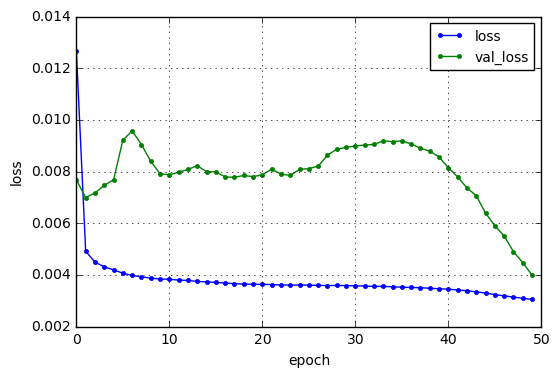

this data had finished making
hiden node = 16
_dim=16_Win=0512_Sld=0064_rmsprop_Sparse
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.0206 - val_loss: 0.0237
Epoch 2/50
1s - loss: 0.0085 - val_loss: 0.0251
Epoch 3/50
2s - loss: 0.0079 - val_loss: 0.0269
Epoch 4/50
2s - loss: 0.0076 - val_loss: 0.0290
Epoch 5/50
2s - loss: 0.0073 - val_loss: 0.0315
Epoch 6/50
2s - loss: 0.0071 - val_loss: 0.0312
Epoch 7/50
2s - loss: 0.0070 - val_loss: 0.0314
Epoch 8/50
2s - loss: 0.0068 - val_loss: 0.0328
Epoch 9/50
2s - loss: 0.0068 - val_loss: 0.0347
Epoch 10/50
2s - loss: 0.0066 - val_loss: 0.0348
Epoch 11/50
2s - loss: 0.0066 - val_loss: 0.0347
Epoch 12/50
2s - loss: 0.0065 - val_loss: 0.0343
Epoch 13/50
2s - loss: 0.0064 - val_loss: 0.0343
Epoch 14/50
2s - loss: 0.0063 - val_loss: 0.0340
Epoch 15/50
2s - loss: 0.0062 - val_loss: 0.0354
Epoch 16/50
2s - loss: 0.0062 - val_loss: 0.0345
Epoch 17/50
2s - loss: 0.0062 - val_loss: 0.0339
Epoch 18/50
2s - loss: 0.0061 - val_los

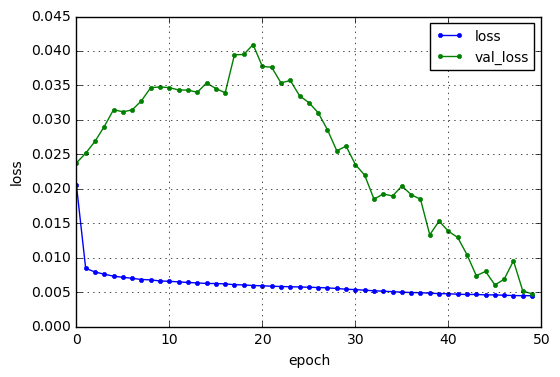

this data had finished making
hiden node = 16
_dim=16_Win=1024_Sld=0128_rmsprop_Sparse
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
1s - loss: 0.0351 - val_loss: 0.0152
Epoch 2/50
1s - loss: 0.0146 - val_loss: 0.0173
Epoch 3/50
1s - loss: 0.0141 - val_loss: 0.0251
Epoch 4/50
1s - loss: 0.0137 - val_loss: 0.0277
Epoch 5/50
1s - loss: 0.0132 - val_loss: 0.0304
Epoch 6/50
1s - loss: 0.0128 - val_loss: 0.0270
Epoch 7/50
1s - loss: 0.0124 - val_loss: 0.0332
Epoch 8/50
1s - loss: 0.0123 - val_loss: 0.0246
Epoch 9/50
1s - loss: 0.0121 - val_loss: 0.0302
Epoch 10/50
1s - loss: 0.0119 - val_loss: 0.0295
Epoch 11/50
1s - loss: 0.0117 - val_loss: 0.0391
Epoch 12/50
1s - loss: 0.0116 - val_loss: 0.0342
Epoch 13/50
1s - loss: 0.0116 - val_loss: 0.0183
Epoch 14/50
1s - loss: 0.0115 - val_loss: 0.0417
Epoch 15/50
1s - loss: 0.0114 - val_loss: 0.0511
Epoch 16/50
1s - loss: 0.0113 - val_loss: 0.0383
Epoch 17/50
1s - loss: 0.0113 - val_loss: 0.0287
Epoch 18/50
1s - loss: 0.0113 - val_loss:

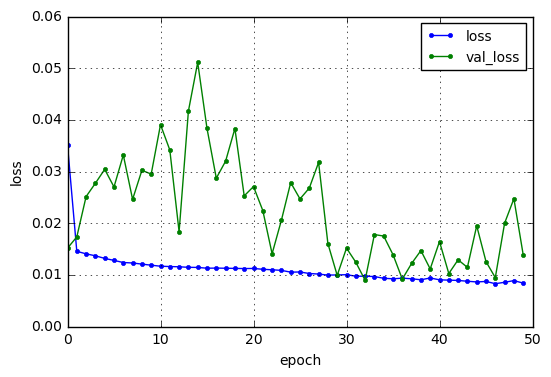

this data had finished making
hiden node = 16
_dim=16_Win=2048_Sld=0256_rmsprop_Sparse
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0576 - val_loss: 0.0380
Epoch 2/50
0s - loss: 0.0273 - val_loss: 0.0398
Epoch 3/50
0s - loss: 0.0244 - val_loss: 0.0360
Epoch 4/50
0s - loss: 0.0247 - val_loss: 0.0412
Epoch 5/50
0s - loss: 0.0245 - val_loss: 0.0426
Epoch 6/50
0s - loss: 0.0248 - val_loss: 0.0716
Epoch 7/50
0s - loss: 0.0231 - val_loss: 0.0306
Epoch 8/50
0s - loss: 0.0232 - val_loss: 0.0311
Epoch 9/50
0s - loss: 0.0234 - val_loss: 0.0326
Epoch 10/50
0s - loss: 0.0218 - val_loss: 0.0520
Epoch 11/50
0s - loss: 0.0230 - val_loss: 0.0210
Epoch 12/50
0s - loss: 0.0220 - val_loss: 0.0184
Epoch 13/50
0s - loss: 0.0217 - val_loss: 0.0377
Epoch 14/50
0s - loss: 0.0208 - val_loss: 0.0507
Epoch 15/50
0s - loss: 0.0226 - val_loss: 0.0235
Epoch 16/50
0s - loss: 0.0227 - val_loss: 0.0416
Epoch 17/50
0s - loss: 0.0213 - val_loss: 0.0384
Epoch 18/50
0s - loss: 0.0197 - val_loss:

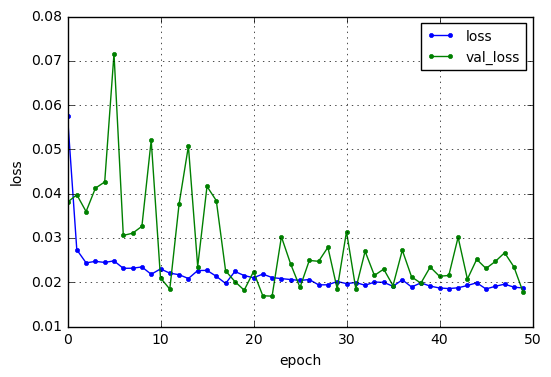

this data had finished making
hiden node = 16
_dim=16_Win=4096_Sld=0512_rmsprop_Sparse
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.0863 - val_loss: 0.0562
Epoch 2/50
0s - loss: 0.0502 - val_loss: 0.0475
Epoch 3/50
0s - loss: 0.0439 - val_loss: 0.0437
Epoch 4/50
0s - loss: 0.0457 - val_loss: 0.0552
Epoch 5/50
0s - loss: 0.0449 - val_loss: 0.0427
Epoch 6/50
0s - loss: 0.0453 - val_loss: 0.0822
Epoch 7/50
0s - loss: 0.0423 - val_loss: 0.0565
Epoch 8/50
0s - loss: 0.0467 - val_loss: 0.0600
Epoch 9/50
0s - loss: 0.0422 - val_loss: 0.0699
Epoch 10/50
0s - loss: 0.0443 - val_loss: 0.0509
Epoch 11/50
0s - loss: 0.0447 - val_loss: 0.0738
Epoch 12/50
0s - loss: 0.0447 - val_loss: 0.0457
Epoch 13/50
0s - loss: 0.0418 - val_loss: 0.0424
Epoch 14/50
0s - loss: 0.0443 - val_loss: 0.0533
Epoch 15/50
0s - loss: 0.0464 - val_loss: 0.0615
Epoch 16/50
0s - loss: 0.0460 - val_loss: 0.0561
Epoch 17/50
0s - loss: 0.0411 - val_loss: 0.0503
Epoch 18/50
0s - loss: 0.0434 - val_loss:

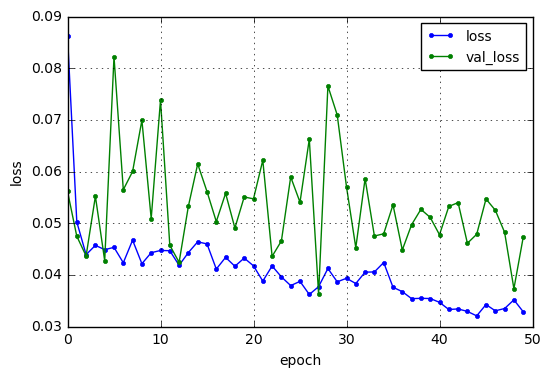

In [40]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 16
Optim='rmsprop'
AEDimention = 16

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    
    CommonName='_dim='+str(AEDimention)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+'_Sparse'
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    SparseAutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

電話を受けてやっていくこと  
まず，学習方法のパラメータを変更して見ていく．  
まず，中間層の値を変えてみるー＞入力データと同じ，２分の１，４分の１，８分の１でやる  
次に，最適化法保をＳＧＤ試す  

this data had finished making
hiden node = 256
_AEdim=256_Win=0256_Sld=0032_sgd_Sparse
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0467 - val_loss: 0.0132
Epoch 2/50
1s - loss: 0.0106 - val_loss: 0.0119
Epoch 3/50
2s - loss: 0.0097 - val_loss: 0.0109
Epoch 4/50
2s - loss: 0.0090 - val_loss: 0.0101
Epoch 5/50
2s - loss: 0.0084 - val_loss: 0.0095
Epoch 6/50
2s - loss: 0.0080 - val_loss: 0.0090
Epoch 7/50
2s - loss: 0.0076 - val_loss: 0.0085
Epoch 8/50
2s - loss: 0.0073 - val_loss: 0.0082
Epoch 9/50
2s - loss: 0.0070 - val_loss: 0.0079
Epoch 10/50
2s - loss: 0.0068 - val_loss: 0.0076
Epoch 11/50
2s - loss: 0.0066 - val_loss: 0.0073
Epoch 12/50
2s - loss: 0.0064 - val_loss: 0.0071
Epoch 13/50
2s - loss: 0.0062 - val_loss: 0.0069
Epoch 14/50
2s - loss: 0.0060 - val_loss: 0.0067
Epoch 15/50
2s - loss: 0.0059 - val_loss: 0.0066
Epoch 16/50
2s - loss: 0.0057 - val_loss: 0.0064
Epoch 17/50
2s - loss: 0.0056 - val_loss: 0.0063
Epoch 18/50
2s - loss: 0.0055 - val_los

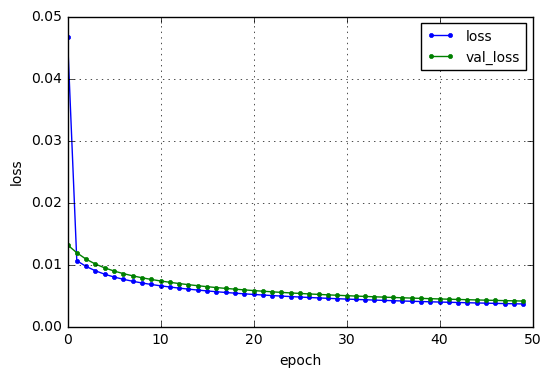

hiden node = 128
_AEdim=128_Win=0256_Sld=0032_sgd_Sparse
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.0882 - val_loss: 0.0155
Epoch 2/50
2s - loss: 0.0126 - val_loss: 0.0134
Epoch 3/50
2s - loss: 0.0111 - val_loss: 0.0121
Epoch 4/50
2s - loss: 0.0101 - val_loss: 0.0113
Epoch 5/50
2s - loss: 0.0094 - val_loss: 0.0106
Epoch 6/50
2s - loss: 0.0089 - val_loss: 0.0101
Epoch 7/50
2s - loss: 0.0085 - val_loss: 0.0097
Epoch 8/50
2s - loss: 0.0082 - val_loss: 0.0094
Epoch 9/50
2s - loss: 0.0079 - val_loss: 0.0091
Epoch 10/50
2s - loss: 0.0077 - val_loss: 0.0088
Epoch 11/50
2s - loss: 0.0075 - val_loss: 0.0086
Epoch 12/50
2s - loss: 0.0073 - val_loss: 0.0084
Epoch 13/50
2s - loss: 0.0071 - val_loss: 0.0082
Epoch 14/50
2s - loss: 0.0070 - val_loss: 0.0080
Epoch 15/50
2s - loss: 0.0068 - val_loss: 0.0079
Epoch 16/50
2s - loss: 0.0067 - val_loss: 0.0077
Epoch 17/50
2s - loss: 0.0066 - val_loss: 0.0076
Epoch 18/50
2s - loss: 0.0064 - val_loss: 0.0074
Epoch 19/50
2s - los

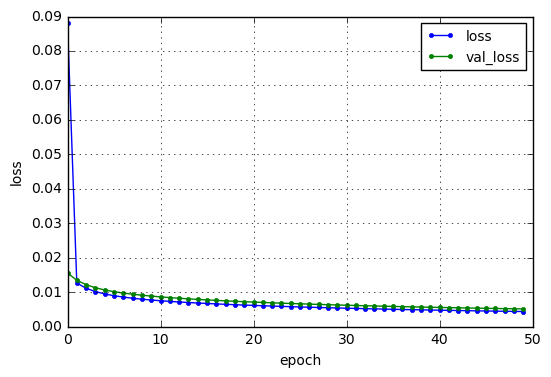

hiden node = 64
_AEdim=064_Win=0256_Sld=0032_sgd_Sparse
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.1114 - val_loss: 0.0244
Epoch 2/50
2s - loss: 0.0164 - val_loss: 0.0150
Epoch 3/50
2s - loss: 0.0124 - val_loss: 0.0131
Epoch 4/50
2s - loss: 0.0108 - val_loss: 0.0119
Epoch 5/50
2s - loss: 0.0099 - val_loss: 0.0112
Epoch 6/50
2s - loss: 0.0093 - val_loss: 0.0107
Epoch 7/50
2s - loss: 0.0088 - val_loss: 0.0103
Epoch 8/50
2s - loss: 0.0085 - val_loss: 0.0100
Epoch 9/50
2s - loss: 0.0082 - val_loss: 0.0098
Epoch 10/50
2s - loss: 0.0080 - val_loss: 0.0095
Epoch 11/50
1s - loss: 0.0078 - val_loss: 0.0093
Epoch 12/50
1s - loss: 0.0076 - val_loss: 0.0091
Epoch 13/50
1s - loss: 0.0074 - val_loss: 0.0090
Epoch 14/50
2s - loss: 0.0073 - val_loss: 0.0088
Epoch 15/50
2s - loss: 0.0072 - val_loss: 0.0087
Epoch 16/50
2s - loss: 0.0071 - val_loss: 0.0085
Epoch 17/50
2s - loss: 0.0070 - val_loss: 0.0084
Epoch 18/50
2s - loss: 0.0069 - val_loss: 0.0083
Epoch 19/50
2s - loss

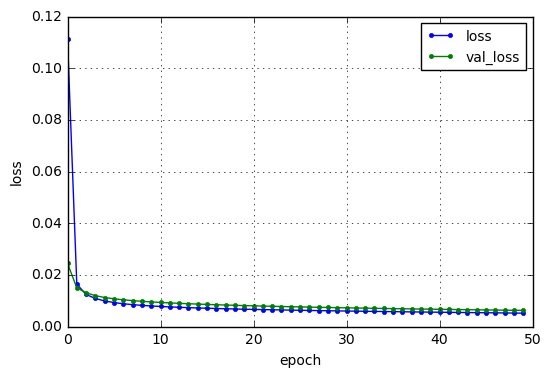

hiden node = 32
_AEdim=032_Win=0256_Sld=0032_sgd_Sparse
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.1595 - val_loss: 0.0647
Epoch 2/50
2s - loss: 0.0359 - val_loss: 0.0230
Epoch 3/50
2s - loss: 0.0185 - val_loss: 0.0172
Epoch 4/50
2s - loss: 0.0143 - val_loss: 0.0148
Epoch 5/50
2s - loss: 0.0122 - val_loss: 0.0135
Epoch 6/50
2s - loss: 0.0110 - val_loss: 0.0127
Epoch 7/50
2s - loss: 0.0101 - val_loss: 0.0121
Epoch 8/50
2s - loss: 0.0096 - val_loss: 0.0117
Epoch 9/50
2s - loss: 0.0091 - val_loss: 0.0114
Epoch 10/50
1s - loss: 0.0088 - val_loss: 0.0111
Epoch 11/50
1s - loss: 0.0085 - val_loss: 0.0108
Epoch 12/50
1s - loss: 0.0083 - val_loss: 0.0106
Epoch 13/50
2s - loss: 0.0081 - val_loss: 0.0104
Epoch 14/50
2s - loss: 0.0080 - val_loss: 0.0103
Epoch 15/50
2s - loss: 0.0078 - val_loss: 0.0101
Epoch 16/50
2s - loss: 0.0077 - val_loss: 0.0100
Epoch 17/50
2s - loss: 0.0076 - val_loss: 0.0098
Epoch 18/50
2s - loss: 0.0075 - val_loss: 0.0097
Epoch 19/50
2s - loss

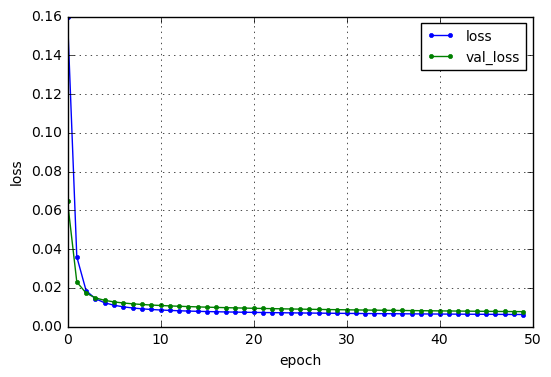

this data had finished making
hiden node = 512
_AEdim=512_Win=0512_Sld=0064_sgd_Sparse
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.0892 - val_loss: 0.0186
Epoch 2/50
1s - loss: 0.0160 - val_loss: 0.0158
Epoch 3/50
1s - loss: 0.0147 - val_loss: 0.0149
Epoch 4/50
1s - loss: 0.0139 - val_loss: 0.0142
Epoch 5/50
1s - loss: 0.0132 - val_loss: 0.0135
Epoch 6/50
1s - loss: 0.0126 - val_loss: 0.0129
Epoch 7/50
1s - loss: 0.0121 - val_loss: 0.0124
Epoch 8/50
1s - loss: 0.0117 - val_loss: 0.0120
Epoch 9/50
1s - loss: 0.0113 - val_loss: 0.0116
Epoch 10/50
1s - loss: 0.0109 - val_loss: 0.0112
Epoch 11/50
1s - loss: 0.0106 - val_loss: 0.0109
Epoch 12/50
0s - loss: 0.0103 - val_loss: 0.0106
Epoch 13/50
1s - loss: 0.0100 - val_loss: 0.0103
Epoch 14/50
1s - loss: 0.0097 - val_loss: 0.0100
Epoch 15/50
1s - loss: 0.0095 - val_loss: 0.0098
Epoch 16/50
1s - loss: 0.0093 - val_loss: 0.0096
Epoch 17/50
1s - loss: 0.0091 - val_loss: 0.0094
Epoch 18/50
1s - loss: 0.0089 - val_los

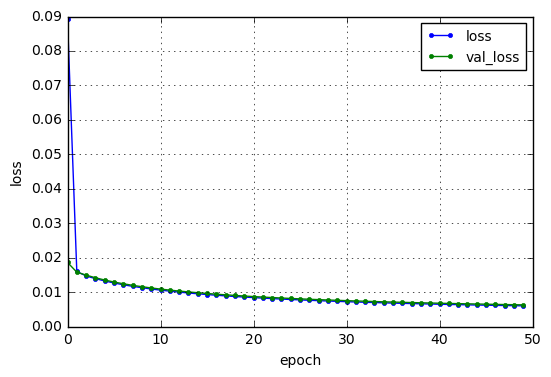

hiden node = 256
_AEdim=256_Win=0512_Sld=0064_sgd_Sparse
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.1316 - val_loss: 0.0350
Epoch 2/50
1s - loss: 0.0222 - val_loss: 0.0175
Epoch 3/50
1s - loss: 0.0162 - val_loss: 0.0161
Epoch 4/50
1s - loss: 0.0152 - val_loss: 0.0153
Epoch 5/50
1s - loss: 0.0145 - val_loss: 0.0146
Epoch 6/50
1s - loss: 0.0138 - val_loss: 0.0141
Epoch 7/50
1s - loss: 0.0133 - val_loss: 0.0136
Epoch 8/50
0s - loss: 0.0129 - val_loss: 0.0131
Epoch 9/50
0s - loss: 0.0125 - val_loss: 0.0128
Epoch 10/50
1s - loss: 0.0121 - val_loss: 0.0124
Epoch 11/50
1s - loss: 0.0118 - val_loss: 0.0121
Epoch 12/50
1s - loss: 0.0115 - val_loss: 0.0119
Epoch 13/50
1s - loss: 0.0113 - val_loss: 0.0116
Epoch 14/50
1s - loss: 0.0110 - val_loss: 0.0114
Epoch 15/50
1s - loss: 0.0108 - val_loss: 0.0112
Epoch 16/50
1s - loss: 0.0106 - val_loss: 0.0110
Epoch 17/50
1s - loss: 0.0104 - val_loss: 0.0108
Epoch 18/50
1s - loss: 0.0102 - val_loss: 0.0106
Epoch 19/50
1s - los

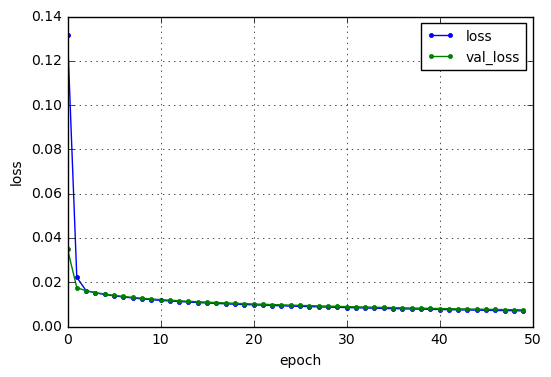

hiden node = 128
_AEdim=128_Win=0512_Sld=0064_sgd_Sparse
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.1892 - val_loss: 0.0895
Epoch 2/50
1s - loss: 0.0508 - val_loss: 0.0288
Epoch 3/50
1s - loss: 0.0227 - val_loss: 0.0196
Epoch 4/50
1s - loss: 0.0181 - val_loss: 0.0176
Epoch 5/50
0s - loss: 0.0165 - val_loss: 0.0164
Epoch 6/50
0s - loss: 0.0155 - val_loss: 0.0155
Epoch 7/50
0s - loss: 0.0147 - val_loss: 0.0149
Epoch 8/50
1s - loss: 0.0141 - val_loss: 0.0143
Epoch 9/50
1s - loss: 0.0136 - val_loss: 0.0139
Epoch 10/50
1s - loss: 0.0131 - val_loss: 0.0135
Epoch 11/50
1s - loss: 0.0127 - val_loss: 0.0132
Epoch 12/50
1s - loss: 0.0124 - val_loss: 0.0129
Epoch 13/50
1s - loss: 0.0121 - val_loss: 0.0126
Epoch 14/50
1s - loss: 0.0119 - val_loss: 0.0124
Epoch 15/50
1s - loss: 0.0116 - val_loss: 0.0122
Epoch 16/50
1s - loss: 0.0114 - val_loss: 0.0120
Epoch 17/50
1s - loss: 0.0112 - val_loss: 0.0118
Epoch 18/50
1s - loss: 0.0110 - val_loss: 0.0117
Epoch 19/50
1s - los

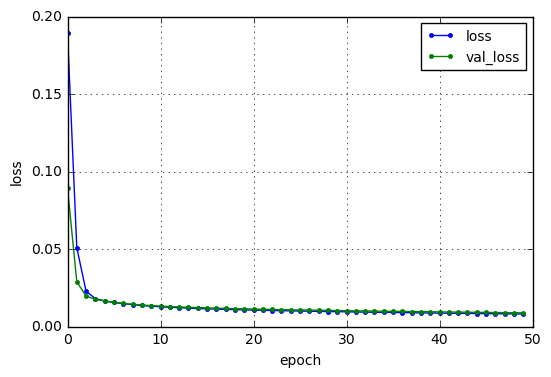

hiden node = 64
_AEdim=064_Win=0512_Sld=0064_sgd_Sparse
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.2356 - val_loss: 0.1669
Epoch 2/50
1s - loss: 0.1127 - val_loss: 0.0698
Epoch 3/50
1s - loss: 0.0484 - val_loss: 0.0341
Epoch 4/50
1s - loss: 0.0279 - val_loss: 0.0239
Epoch 5/50
1s - loss: 0.0216 - val_loss: 0.0203
Epoch 6/50
1s - loss: 0.0189 - val_loss: 0.0184
Epoch 7/50
1s - loss: 0.0173 - val_loss: 0.0171
Epoch 8/50
1s - loss: 0.0161 - val_loss: 0.0162
Epoch 9/50
1s - loss: 0.0153 - val_loss: 0.0155
Epoch 10/50
1s - loss: 0.0146 - val_loss: 0.0149
Epoch 11/50
0s - loss: 0.0141 - val_loss: 0.0145
Epoch 12/50
0s - loss: 0.0136 - val_loss: 0.0142
Epoch 13/50
0s - loss: 0.0133 - val_loss: 0.0139
Epoch 14/50
0s - loss: 0.0129 - val_loss: 0.0136
Epoch 15/50
1s - loss: 0.0127 - val_loss: 0.0134
Epoch 16/50
1s - loss: 0.0124 - val_loss: 0.0132
Epoch 17/50
1s - loss: 0.0122 - val_loss: 0.0131
Epoch 18/50
1s - loss: 0.0120 - val_loss: 0.0129
Epoch 19/50
1s - loss

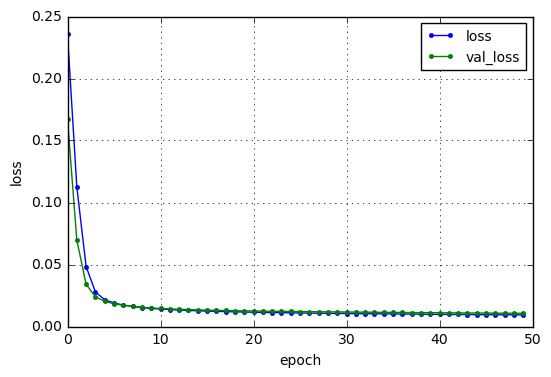

this data had finished making
hiden node = 1024
_AEdim=1024_Win=1024_Sld=0128_sgd_Sparse
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
2s - loss: 0.1631 - val_loss: 0.0587
Epoch 2/50
3s - loss: 0.0387 - val_loss: 0.0285
Epoch 3/50
3s - loss: 0.0258 - val_loss: 0.0243
Epoch 4/50
3s - loss: 0.0234 - val_loss: 0.0229
Epoch 5/50
3s - loss: 0.0222 - val_loss: 0.0218
Epoch 6/50
3s - loss: 0.0212 - val_loss: 0.0209
Epoch 7/50
3s - loss: 0.0204 - val_loss: 0.0201
Epoch 8/50
3s - loss: 0.0196 - val_loss: 0.0194
Epoch 9/50
3s - loss: 0.0189 - val_loss: 0.0187
Epoch 10/50
3s - loss: 0.0182 - val_loss: 0.0181
Epoch 11/50
1s - loss: 0.0177 - val_loss: 0.0175
Epoch 12/50
1s - loss: 0.0171 - val_loss: 0.0170
Epoch 13/50
2s - loss: 0.0166 - val_loss: 0.0165
Epoch 14/50
2s - loss: 0.0162 - val_loss: 0.0161
Epoch 15/50
2s - loss: 0.0158 - val_loss: 0.0157
Epoch 16/50
2s - loss: 0.0154 - val_loss: 0.0153
Epoch 17/50
2s - loss: 0.0150 - val_loss: 0.0149
Epoch 18/50
2s - loss: 0.0147 - val_los

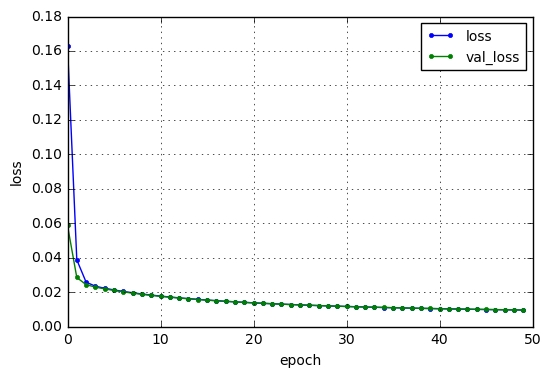

hiden node = 512
_AEdim=512_Win=1024_Sld=0128_sgd_Sparse
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
1s - loss: 0.2170 - val_loss: 0.1156
Epoch 2/50
1s - loss: 0.0766 - val_loss: 0.0495
Epoch 3/50
1s - loss: 0.0380 - val_loss: 0.0304
Epoch 4/50
1s - loss: 0.0273 - val_loss: 0.0253
Epoch 5/50
1s - loss: 0.0242 - val_loss: 0.0234
Epoch 6/50
1s - loss: 0.0228 - val_loss: 0.0224
Epoch 7/50
1s - loss: 0.0219 - val_loss: 0.0216
Epoch 8/50
1s - loss: 0.0211 - val_loss: 0.0209
Epoch 9/50
1s - loss: 0.0204 - val_loss: 0.0202
Epoch 10/50
1s - loss: 0.0198 - val_loss: 0.0196
Epoch 11/50
1s - loss: 0.0193 - val_loss: 0.0191
Epoch 12/50
1s - loss: 0.0187 - val_loss: 0.0186
Epoch 13/50
1s - loss: 0.0183 - val_loss: 0.0181
Epoch 14/50
1s - loss: 0.0178 - val_loss: 0.0177
Epoch 15/50
1s - loss: 0.0174 - val_loss: 0.0173
Epoch 16/50
1s - loss: 0.0170 - val_loss: 0.0170
Epoch 17/50
1s - loss: 0.0167 - val_loss: 0.0166
Epoch 18/50
1s - loss: 0.0164 - val_loss: 0.0163
Epoch 19/50
1s - loss:

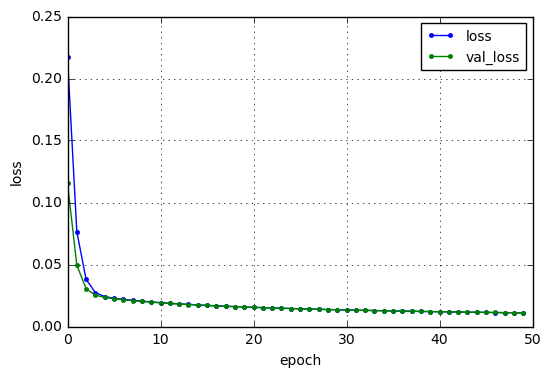

hiden node = 256
_AEdim=256_Win=1024_Sld=0128_sgd_Sparse
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
1s - loss: 0.2470 - val_loss: 0.1734
Epoch 2/50
0s - loss: 0.1306 - val_loss: 0.0944
Epoch 3/50
0s - loss: 0.0712 - val_loss: 0.0531
Epoch 4/50
0s - loss: 0.0430 - val_loss: 0.0355
Epoch 5/50
0s - loss: 0.0315 - val_loss: 0.0286
Epoch 6/50
0s - loss: 0.0269 - val_loss: 0.0256
Epoch 7/50
0s - loss: 0.0247 - val_loss: 0.0240
Epoch 8/50
0s - loss: 0.0234 - val_loss: 0.0230
Epoch 9/50
0s - loss: 0.0225 - val_loss: 0.0222
Epoch 10/50
0s - loss: 0.0218 - val_loss: 0.0216
Epoch 11/50
0s - loss: 0.0212 - val_loss: 0.0210
Epoch 12/50
0s - loss: 0.0206 - val_loss: 0.0204
Epoch 13/50
0s - loss: 0.0201 - val_loss: 0.0200
Epoch 14/50
0s - loss: 0.0196 - val_loss: 0.0195
Epoch 15/50
0s - loss: 0.0192 - val_loss: 0.0191
Epoch 16/50
0s - loss: 0.0188 - val_loss: 0.0188
Epoch 17/50
0s - loss: 0.0185 - val_loss: 0.0184
Epoch 18/50
0s - loss: 0.0182 - val_loss: 0.0181
Epoch 19/50
0s - loss:

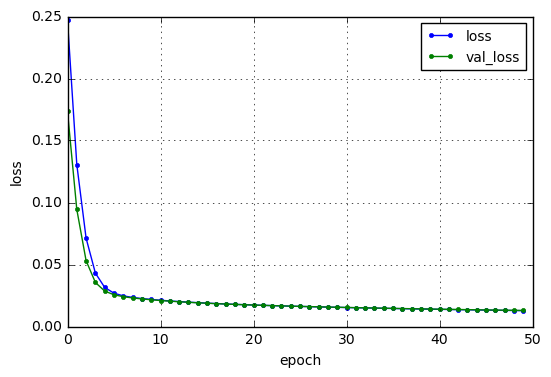

hiden node = 128
_AEdim=128_Win=1024_Sld=0128_sgd_Sparse
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2719 - val_loss: 0.2262
Epoch 2/50
0s - loss: 0.1932 - val_loss: 0.1614
Epoch 3/50
0s - loss: 0.1340 - val_loss: 0.1091
Epoch 4/50
0s - loss: 0.0901 - val_loss: 0.0738
Epoch 5/50
0s - loss: 0.0624 - val_loss: 0.0528
Epoch 6/50
0s - loss: 0.0464 - val_loss: 0.0411
Epoch 7/50
0s - loss: 0.0376 - val_loss: 0.0346
Epoch 8/50
0s - loss: 0.0325 - val_loss: 0.0308
Epoch 9/50
0s - loss: 0.0295 - val_loss: 0.0284
Epoch 10/50
0s - loss: 0.0275 - val_loss: 0.0267
Epoch 11/50
0s - loss: 0.0260 - val_loss: 0.0254
Epoch 12/50
0s - loss: 0.0249 - val_loss: 0.0244
Epoch 13/50
0s - loss: 0.0239 - val_loss: 0.0236
Epoch 14/50
0s - loss: 0.0231 - val_loss: 0.0229
Epoch 15/50
0s - loss: 0.0225 - val_loss: 0.0223
Epoch 16/50
0s - loss: 0.0219 - val_loss: 0.0217
Epoch 17/50
0s - loss: 0.0214 - val_loss: 0.0213
Epoch 18/50
0s - loss: 0.0209 - val_loss: 0.0209
Epoch 19/50
0s - loss:

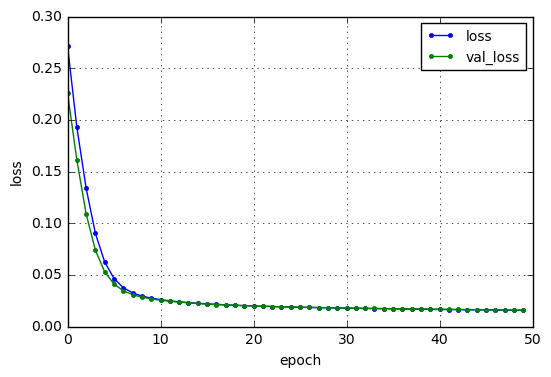

this data had finished making
hiden node = 2048
_AEdim=2048_Win=2048_Sld=0256_sgd_Sparse
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
1s - loss: 0.2594 - val_loss: 0.1455
Epoch 2/50
1s - loss: 0.1033 - val_loss: 0.0735
Epoch 3/50
1s - loss: 0.0594 - val_loss: 0.0489
Epoch 4/50
1s - loss: 0.0438 - val_loss: 0.0398
Epoch 5/50
1s - loss: 0.0376 - val_loss: 0.0359
Epoch 6/50
1s - loss: 0.0348 - val_loss: 0.0338
Epoch 7/50
1s - loss: 0.0331 - val_loss: 0.0324
Epoch 8/50
1s - loss: 0.0318 - val_loss: 0.0312
Epoch 9/50
1s - loss: 0.0307 - val_loss: 0.0302
Epoch 10/50
1s - loss: 0.0297 - val_loss: 0.0293
Epoch 11/50
1s - loss: 0.0288 - val_loss: 0.0284
Epoch 12/50
1s - loss: 0.0280 - val_loss: 0.0276
Epoch 13/50
1s - loss: 0.0272 - val_loss: 0.0269
Epoch 14/50
1s - loss: 0.0265 - val_loss: 0.0262
Epoch 15/50
1s - loss: 0.0259 - val_loss: 0.0255
Epoch 16/50
1s - loss: 0.0252 - val_loss: 0.0249
Epoch 17/50
1s - loss: 0.0246 - val_loss: 0.0244
Epoch 18/50
1s - loss: 0.0241 - val_los

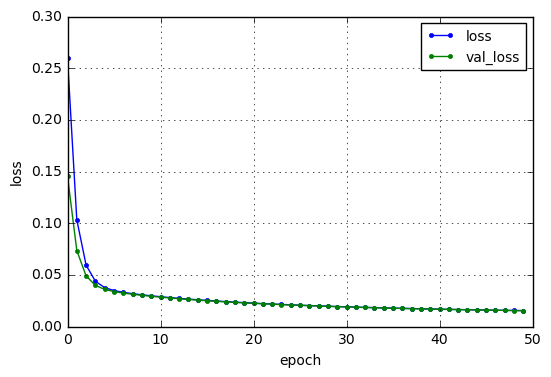

hiden node = 1024
_AEdim=1024_Win=2048_Sld=0256_sgd_Sparse
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
1s - loss: 0.2892 - val_loss: 0.2038
Epoch 2/50
1s - loss: 0.1627 - val_loss: 0.1289
Epoch 3/50
1s - loss: 0.1063 - val_loss: 0.0868
Epoch 4/50
1s - loss: 0.0737 - val_loss: 0.0625
Epoch 5/50
1s - loss: 0.0551 - val_loss: 0.0490
Epoch 6/50
1s - loss: 0.0451 - val_loss: 0.0417
Epoch 7/50
1s - loss: 0.0396 - val_loss: 0.0377
Epoch 8/50
1s - loss: 0.0365 - val_loss: 0.0354
Epoch 9/50
1s - loss: 0.0346 - val_loss: 0.0339
Epoch 10/50
1s - loss: 0.0333 - val_loss: 0.0328
Epoch 11/50
1s - loss: 0.0324 - val_loss: 0.0319
Epoch 12/50
1s - loss: 0.0316 - val_loss: 0.0312
Epoch 13/50
1s - loss: 0.0309 - val_loss: 0.0305
Epoch 14/50
1s - loss: 0.0302 - val_loss: 0.0299
Epoch 15/50
1s - loss: 0.0296 - val_loss: 0.0294
Epoch 16/50
1s - loss: 0.0291 - val_loss: 0.0288
Epoch 17/50
1s - loss: 0.0286 - val_loss: 0.0283
Epoch 18/50
1s - loss: 0.0281 - val_loss: 0.0278
Epoch 19/50
1s - los

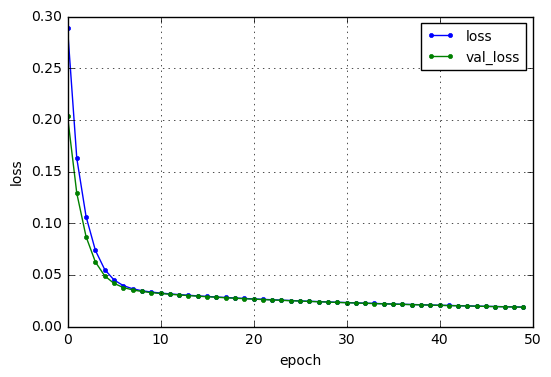

hiden node = 512
_AEdim=512_Win=2048_Sld=0256_sgd_Sparse
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.3061 - val_loss: 0.2504
Epoch 2/50
0s - loss: 0.2188 - val_loss: 0.1912
Epoch 3/50
0s - loss: 0.1692 - val_loss: 0.1483
Epoch 4/50
0s - loss: 0.1308 - val_loss: 0.1143
Epoch 5/50
0s - loss: 0.1009 - val_loss: 0.0884
Epoch 6/50
0s - loss: 0.0788 - val_loss: 0.0700
Epoch 7/50
0s - loss: 0.0634 - val_loss: 0.0574
Epoch 8/50
0s - loss: 0.0531 - val_loss: 0.0491
Epoch 9/50
0s - loss: 0.0463 - val_loss: 0.0437
Epoch 10/50
0s - loss: 0.0418 - val_loss: 0.0402
Epoch 11/50
0s - loss: 0.0389 - val_loss: 0.0378
Epoch 12/50
0s - loss: 0.0369 - val_loss: 0.0361
Epoch 13/50
0s - loss: 0.0355 - val_loss: 0.0349
Epoch 14/50
0s - loss: 0.0344 - val_loss: 0.0340
Epoch 15/50
0s - loss: 0.0336 - val_loss: 0.0332
Epoch 16/50
0s - loss: 0.0329 - val_loss: 0.0326
Epoch 17/50
0s - loss: 0.0323 - val_loss: 0.0320
Epoch 18/50
0s - loss: 0.0318 - val_loss: 0.0315
Epoch 19/50
0s - loss:

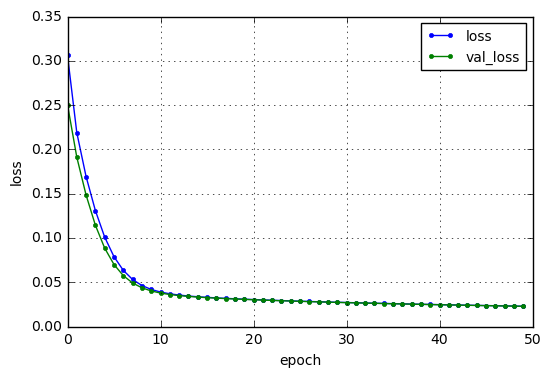

hiden node = 256
_AEdim=256_Win=2048_Sld=0256_sgd_Sparse
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2973 - val_loss: 0.2676
Epoch 2/50
0s - loss: 0.2501 - val_loss: 0.2343
Epoch 3/50
0s - loss: 0.2201 - val_loss: 0.2057
Epoch 4/50
0s - loss: 0.1917 - val_loss: 0.1774
Epoch 5/50
0s - loss: 0.1639 - val_loss: 0.1504
Epoch 6/50
0s - loss: 0.1382 - val_loss: 0.1263
Epoch 7/50
0s - loss: 0.1159 - val_loss: 0.1058
Epoch 8/50
0s - loss: 0.0973 - val_loss: 0.0893
Epoch 9/50
0s - loss: 0.0826 - val_loss: 0.0762
Epoch 10/50
0s - loss: 0.0711 - val_loss: 0.0662
Epoch 11/50
0s - loss: 0.0623 - val_loss: 0.0586
Epoch 12/50
0s - loss: 0.0557 - val_loss: 0.0529
Epoch 13/50
0s - loss: 0.0507 - val_loss: 0.0486
Epoch 14/50
0s - loss: 0.0469 - val_loss: 0.0453
Epoch 15/50
0s - loss: 0.0440 - val_loss: 0.0428
Epoch 16/50
0s - loss: 0.0418 - val_loss: 0.0409
Epoch 17/50
0s - loss: 0.0401 - val_loss: 0.0393
Epoch 18/50
0s - loss: 0.0387 - val_loss: 0.0381
Epoch 19/50
0s - loss:

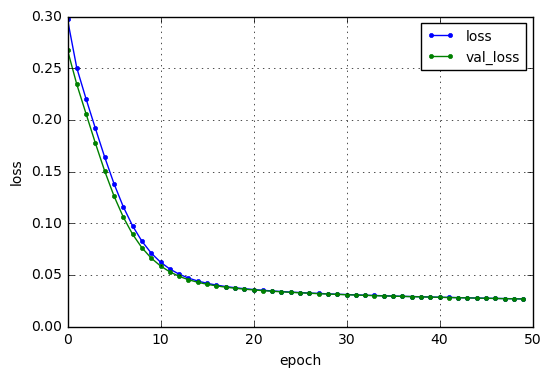

this data had finished making
hiden node = 4096
_AEdim=4096_Win=4096_Sld=0512_sgd_Sparse
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
3s - loss: 0.3458 - val_loss: 0.2532
Epoch 2/50
3s - loss: 0.2050 - val_loss: 0.1650
Epoch 3/50
3s - loss: 0.1407 - val_loss: 0.1195
Epoch 4/50
3s - loss: 0.1057 - val_loss: 0.0932
Epoch 5/50
3s - loss: 0.0849 - val_loss: 0.0773
Epoch 6/50
3s - loss: 0.0722 - val_loss: 0.0674
Epoch 7/50
3s - loss: 0.0641 - val_loss: 0.0611
Epoch 8/50
3s - loss: 0.0589 - val_loss: 0.0569
Epoch 9/50
3s - loss: 0.0554 - val_loss: 0.0539
Epoch 10/50
3s - loss: 0.0528 - val_loss: 0.0517
Epoch 11/50
3s - loss: 0.0509 - val_loss: 0.0500
Epoch 12/50
3s - loss: 0.0493 - val_loss: 0.0486
Epoch 13/50
3s - loss: 0.0480 - val_loss: 0.0474
Epoch 14/50
3s - loss: 0.0468 - val_loss: 0.0463
Epoch 15/50
3s - loss: 0.0458 - val_loss: 0.0453
Epoch 16/50
3s - loss: 0.0448 - val_loss: 0.0443
Epoch 17/50
3s - loss: 0.0439 - val_loss: 0.0434
Epoch 18/50
3s - loss: 0.0431 - val_los

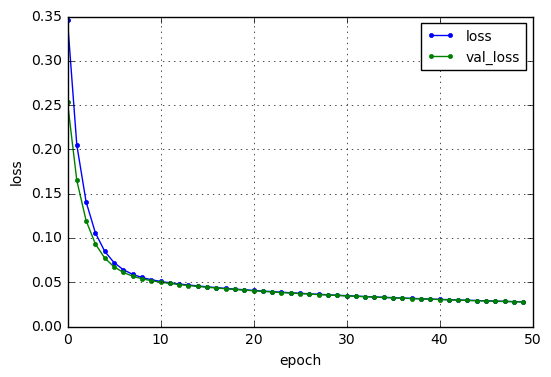

hiden node = 2048
_AEdim=2048_Win=4096_Sld=0512_sgd_Sparse
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
2s - loss: 0.3476 - val_loss: 0.2868
Epoch 2/50
2s - loss: 0.2506 - val_loss: 0.2187
Epoch 3/50
1s - loss: 0.1967 - val_loss: 0.1761
Epoch 4/50
2s - loss: 0.1605 - val_loss: 0.1454
Epoch 5/50
1s - loss: 0.1335 - val_loss: 0.1220
Epoch 6/50
1s - loss: 0.1129 - val_loss: 0.1039
Epoch 7/50
2s - loss: 0.0969 - val_loss: 0.0900
Epoch 8/50
2s - loss: 0.0846 - val_loss: 0.0794
Epoch 9/50
2s - loss: 0.0753 - val_loss: 0.0713
Epoch 10/50
2s - loss: 0.0683 - val_loss: 0.0653
Epoch 11/50
2s - loss: 0.0630 - val_loss: 0.0607
Epoch 12/50
2s - loss: 0.0590 - val_loss: 0.0573
Epoch 13/50
2s - loss: 0.0560 - val_loss: 0.0547
Epoch 14/50
2s - loss: 0.0537 - val_loss: 0.0526
Epoch 15/50
2s - loss: 0.0518 - val_loss: 0.0510
Epoch 16/50
2s - loss: 0.0504 - val_loss: 0.0497
Epoch 17/50
2s - loss: 0.0492 - val_loss: 0.0486
Epoch 18/50
2s - loss: 0.0482 - val_loss: 0.0477
Epoch 19/50
2s - los

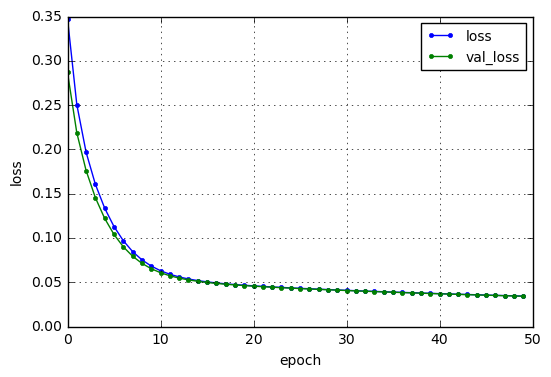

hiden node = 1024
_AEdim=1024_Win=4096_Sld=0512_sgd_Sparse
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
1s - loss: 0.3462 - val_loss: 0.3099
Epoch 2/50
1s - loss: 0.2863 - val_loss: 0.2648
Epoch 3/50
1s - loss: 0.2492 - val_loss: 0.2341
Epoch 4/50
1s - loss: 0.2218 - val_loss: 0.2095
Epoch 5/50
1s - loss: 0.1988 - val_loss: 0.1878
Epoch 6/50
1s - loss: 0.1782 - val_loss: 0.1682
Epoch 7/50
1s - loss: 0.1594 - val_loss: 0.1504
Epoch 8/50
1s - loss: 0.1424 - val_loss: 0.1343
Epoch 9/50
1s - loss: 0.1272 - val_loss: 0.1201
Epoch 10/50
1s - loss: 0.1139 - val_loss: 0.1077
Epoch 11/50
1s - loss: 0.1024 - val_loss: 0.0970
Epoch 12/50
1s - loss: 0.0926 - val_loss: 0.0881
Epoch 13/50
1s - loss: 0.0844 - val_loss: 0.0806
Epoch 14/50
1s - loss: 0.0775 - val_loss: 0.0744
Epoch 15/50
1s - loss: 0.0719 - val_loss: 0.0693
Epoch 16/50
1s - loss: 0.0672 - val_loss: 0.0651
Epoch 17/50
1s - loss: 0.0635 - val_loss: 0.0617
Epoch 18/50
1s - loss: 0.0604 - val_loss: 0.0590
Epoch 19/50
1s - los

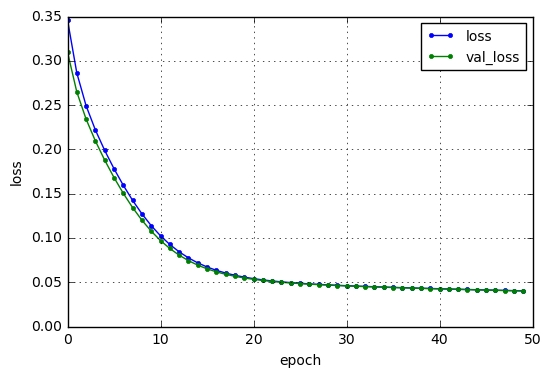

hiden node = 512
_AEdim=512_Win=4096_Sld=0512_sgd_Sparse
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.3213 - val_loss: 0.3018
Epoch 2/50
0s - loss: 0.2881 - val_loss: 0.2752
Epoch 3/50
0s - loss: 0.2653 - val_loss: 0.2557
Epoch 4/50
0s - loss: 0.2475 - val_loss: 0.2391
Epoch 5/50
0s - loss: 0.2315 - val_loss: 0.2236
Epoch 6/50
0s - loss: 0.2164 - val_loss: 0.2088
Epoch 7/50
0s - loss: 0.2018 - val_loss: 0.1945
Epoch 8/50
0s - loss: 0.1877 - val_loss: 0.1806
Epoch 9/50
0s - loss: 0.1741 - val_loss: 0.1672
Epoch 10/50
0s - loss: 0.1611 - val_loss: 0.1546
Epoch 11/50
0s - loss: 0.1488 - val_loss: 0.1428
Epoch 12/50
0s - loss: 0.1374 - val_loss: 0.1319
Epoch 13/50
0s - loss: 0.1270 - val_loss: 0.1219
Epoch 14/50
0s - loss: 0.1175 - val_loss: 0.1129
Epoch 15/50
0s - loss: 0.1090 - val_loss: 0.1049
Epoch 16/50
0s - loss: 0.1013 - val_loss: 0.0977
Epoch 17/50
0s - loss: 0.0946 - val_loss: 0.0914
Epoch 18/50
0s - loss: 0.0886 - val_loss: 0.0858
Epoch 19/50
0s - loss:

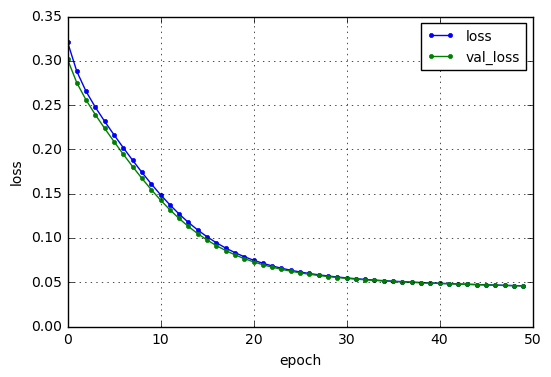

In [41]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
#AEDimention = WindowWidth, WindowWidth/2, WindowWidth/4, WindowWidth/8

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
        
    AEDimentionS=np.array([WindowNum,WindowNum/2,WindowNum/4,WindowNum/8])

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)
    
    for AEDimention in AEDimentionS:
        print "hiden node = "+str(AEDimention)
            
        CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
        '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+'_Sparse'
        print CommonName
      
        SparseAutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

上の結果を見る限り，いい感じに学習できていることがわかった．興味として，上記の中間層の次元以外のパラメータを固定して，さらに次元を圧縮してみる．具体的には，1/8より圧縮してみる．



this data had finished making
hiden node = 32
_AEdim=032_Win=0256_Sld=0032_sgd_Sparse
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.1732 - val_loss: 0.0646
Epoch 2/50
2s - loss: 0.0340 - val_loss: 0.0211
Epoch 3/50
2s - loss: 0.0170 - val_loss: 0.0162
Epoch 4/50
2s - loss: 0.0135 - val_loss: 0.0141
Epoch 5/50
2s - loss: 0.0117 - val_loss: 0.0131
Epoch 6/50
2s - loss: 0.0107 - val_loss: 0.0124
Epoch 7/50
2s - loss: 0.0099 - val_loss: 0.0119
Epoch 8/50
2s - loss: 0.0094 - val_loss: 0.0115
Epoch 9/50
2s - loss: 0.0090 - val_loss: 0.0112
Epoch 10/50
1s - loss: 0.0087 - val_loss: 0.0109
Epoch 11/50
2s - loss: 0.0085 - val_loss: 0.0107
Epoch 12/50
2s - loss: 0.0083 - val_loss: 0.0105
Epoch 13/50
2s - loss: 0.0081 - val_loss: 0.0103
Epoch 14/50
2s - loss: 0.0079 - val_loss: 0.0102
Epoch 15/50
2s - loss: 0.0078 - val_loss: 0.0100
Epoch 16/50
1s - loss: 0.0077 - val_loss: 0.0099
Epoch 17/50
2s - loss: 0.0076 - val_loss: 0.0097
Epoch 18/50
2s - loss: 0.0075 - val_loss

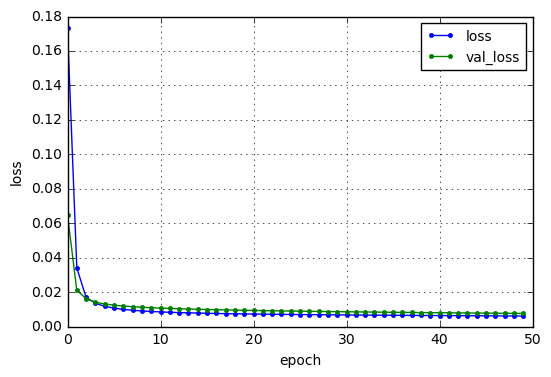

hiden node = 16
_AEdim=016_Win=0256_Sld=0032_sgd_Sparse
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.2042 - val_loss: 0.1238
Epoch 2/50
1s - loss: 0.0765 - val_loss: 0.0462
Epoch 3/50
1s - loss: 0.0343 - val_loss: 0.0273
Epoch 4/50
1s - loss: 0.0226 - val_loss: 0.0207
Epoch 5/50
1s - loss: 0.0175 - val_loss: 0.0175
Epoch 6/50
1s - loss: 0.0146 - val_loss: 0.0157
Epoch 7/50
1s - loss: 0.0128 - val_loss: 0.0146
Epoch 8/50
1s - loss: 0.0116 - val_loss: 0.0138
Epoch 9/50
1s - loss: 0.0108 - val_loss: 0.0132
Epoch 10/50
1s - loss: 0.0102 - val_loss: 0.0128
Epoch 11/50
1s - loss: 0.0097 - val_loss: 0.0124
Epoch 12/50
1s - loss: 0.0093 - val_loss: 0.0121
Epoch 13/50
1s - loss: 0.0090 - val_loss: 0.0119
Epoch 14/50
1s - loss: 0.0087 - val_loss: 0.0117
Epoch 15/50
1s - loss: 0.0085 - val_loss: 0.0115
Epoch 16/50
1s - loss: 0.0083 - val_loss: 0.0113
Epoch 17/50
1s - loss: 0.0082 - val_loss: 0.0111
Epoch 18/50
1s - loss: 0.0081 - val_loss: 0.0109
Epoch 19/50
1s - loss

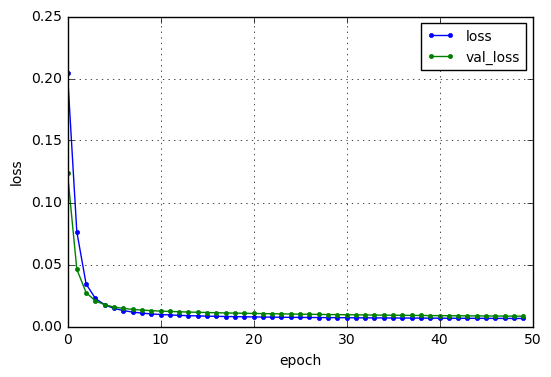

hiden node = 8
_AEdim=008_Win=0256_Sld=0032_sgd_Sparse
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.2266 - val_loss: 0.1605
Epoch 2/50
1s - loss: 0.1127 - val_loss: 0.0770
Epoch 3/50
1s - loss: 0.0588 - val_loss: 0.0458
Epoch 4/50
1s - loss: 0.0383 - val_loss: 0.0329
Epoch 5/50
1s - loss: 0.0285 - val_loss: 0.0260
Epoch 6/50
1s - loss: 0.0226 - val_loss: 0.0219
Epoch 7/50
1s - loss: 0.0189 - val_loss: 0.0193
Epoch 8/50
1s - loss: 0.0164 - val_loss: 0.0176
Epoch 9/50
1s - loss: 0.0146 - val_loss: 0.0164
Epoch 10/50
1s - loss: 0.0133 - val_loss: 0.0155
Epoch 11/50
1s - loss: 0.0124 - val_loss: 0.0148
Epoch 12/50
1s - loss: 0.0116 - val_loss: 0.0143
Epoch 13/50
1s - loss: 0.0110 - val_loss: 0.0139
Epoch 14/50
1s - loss: 0.0105 - val_loss: 0.0136
Epoch 15/50
1s - loss: 0.0102 - val_loss: 0.0133
Epoch 16/50
1s - loss: 0.0098 - val_loss: 0.0131
Epoch 17/50
1s - loss: 0.0095 - val_loss: 0.0129
Epoch 18/50
1s - loss: 0.0093 - val_loss: 0.0127
Epoch 19/50
1s - loss:

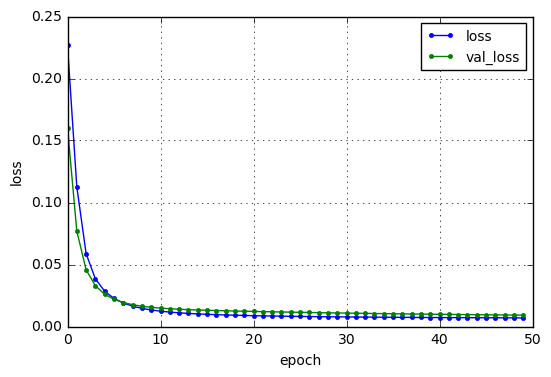

hiden node = 4
_AEdim=004_Win=0256_Sld=0032_sgd_Sparse
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.2560 - val_loss: 0.2182
Epoch 2/50
1s - loss: 0.1818 - val_loss: 0.1495
Epoch 3/50
1s - loss: 0.1248 - val_loss: 0.1031
Epoch 4/50
1s - loss: 0.0871 - val_loss: 0.0735
Epoch 5/50
1s - loss: 0.0639 - val_loss: 0.0558
Epoch 6/50
1s - loss: 0.0494 - val_loss: 0.0442
Epoch 7/50
1s - loss: 0.0394 - val_loss: 0.0362
Epoch 8/50
1s - loss: 0.0323 - val_loss: 0.0305
Epoch 9/50
1s - loss: 0.0271 - val_loss: 0.0264
Epoch 10/50
1s - loss: 0.0233 - val_loss: 0.0234
Epoch 11/50
1s - loss: 0.0205 - val_loss: 0.0211
Epoch 12/50
1s - loss: 0.0183 - val_loss: 0.0194
Epoch 13/50
1s - loss: 0.0167 - val_loss: 0.0181
Epoch 14/50
1s - loss: 0.0154 - val_loss: 0.0171
Epoch 15/50
1s - loss: 0.0144 - val_loss: 0.0163
Epoch 16/50
1s - loss: 0.0135 - val_loss: 0.0157
Epoch 17/50
1s - loss: 0.0128 - val_loss: 0.0152
Epoch 18/50
1s - loss: 0.0123 - val_loss: 0.0148
Epoch 19/50
1s - loss:

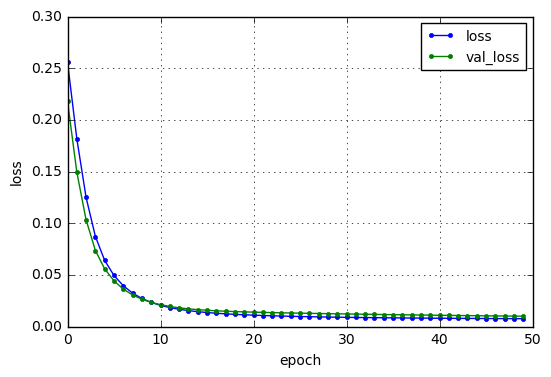

this data had finished making
hiden node = 64
_AEdim=064_Win=0512_Sld=0064_sgd_Sparse
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.2255 - val_loss: 0.1513
Epoch 2/50
0s - loss: 0.1010 - val_loss: 0.0626
Epoch 3/50
0s - loss: 0.0443 - val_loss: 0.0322
Epoch 4/50
0s - loss: 0.0268 - val_loss: 0.0234
Epoch 5/50
0s - loss: 0.0213 - val_loss: 0.0201
Epoch 6/50
0s - loss: 0.0187 - val_loss: 0.0182
Epoch 7/50
0s - loss: 0.0172 - val_loss: 0.0170
Epoch 8/50
0s - loss: 0.0161 - val_loss: 0.0161
Epoch 9/50
0s - loss: 0.0152 - val_loss: 0.0154
Epoch 10/50
0s - loss: 0.0146 - val_loss: 0.0149
Epoch 11/50
0s - loss: 0.0140 - val_loss: 0.0145
Epoch 12/50
0s - loss: 0.0136 - val_loss: 0.0141
Epoch 13/50
0s - loss: 0.0132 - val_loss: 0.0138
Epoch 14/50
0s - loss: 0.0129 - val_loss: 0.0136
Epoch 15/50
0s - loss: 0.0126 - val_loss: 0.0134
Epoch 16/50
0s - loss: 0.0124 - val_loss: 0.0132
Epoch 17/50
0s - loss: 0.0121 - val_loss: 0.0130
Epoch 18/50
0s - loss: 0.0119 - val_loss

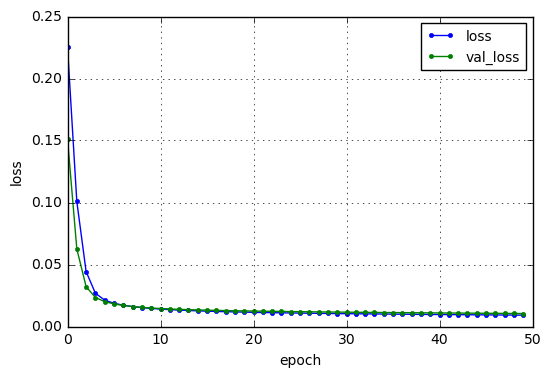

hiden node = 32
_AEdim=032_Win=0512_Sld=0064_sgd_Sparse
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.2532 - val_loss: 0.2092
Epoch 2/50
0s - loss: 0.1669 - val_loss: 0.1274
Epoch 3/50
0s - loss: 0.0983 - val_loss: 0.0744
Epoch 4/50
0s - loss: 0.0595 - val_loss: 0.0479
Epoch 5/50
0s - loss: 0.0408 - val_loss: 0.0353
Epoch 6/50
0s - loss: 0.0316 - val_loss: 0.0288
Epoch 7/50
0s - loss: 0.0265 - val_loss: 0.0249
Epoch 8/50
0s - loss: 0.0232 - val_loss: 0.0222
Epoch 9/50
0s - loss: 0.0209 - val_loss: 0.0204
Epoch 10/50
0s - loss: 0.0192 - val_loss: 0.0191
Epoch 11/50
0s - loss: 0.0180 - val_loss: 0.0181
Epoch 12/50
0s - loss: 0.0170 - val_loss: 0.0173
Epoch 13/50
0s - loss: 0.0162 - val_loss: 0.0167
Epoch 14/50
0s - loss: 0.0155 - val_loss: 0.0162
Epoch 15/50
0s - loss: 0.0150 - val_loss: 0.0158
Epoch 16/50
0s - loss: 0.0145 - val_loss: 0.0154
Epoch 17/50
0s - loss: 0.0141 - val_loss: 0.0151
Epoch 18/50
0s - loss: 0.0138 - val_loss: 0.0149
Epoch 19/50
0s - loss

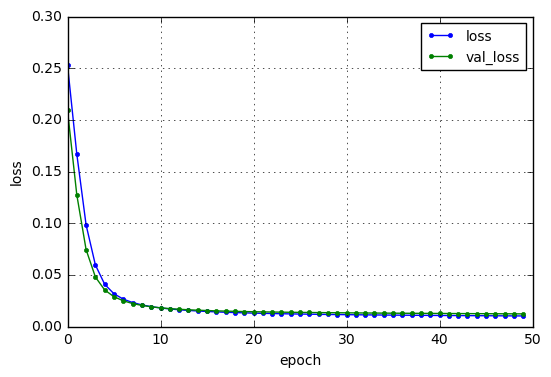

hiden node = 16
_AEdim=016_Win=0512_Sld=0064_sgd_Sparse
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.2694 - val_loss: 0.2410
Epoch 2/50
0s - loss: 0.2110 - val_loss: 0.1806
Epoch 3/50
0s - loss: 0.1537 - val_loss: 0.1293
Epoch 4/50
0s - loss: 0.1106 - val_loss: 0.0942
Epoch 5/50
0s - loss: 0.0821 - val_loss: 0.0715
Epoch 6/50
0s - loss: 0.0637 - val_loss: 0.0569
Epoch 7/50
0s - loss: 0.0517 - val_loss: 0.0471
Epoch 8/50
0s - loss: 0.0435 - val_loss: 0.0403
Epoch 9/50
0s - loss: 0.0376 - val_loss: 0.0353
Epoch 10/50
0s - loss: 0.0331 - val_loss: 0.0315
Epoch 11/50
0s - loss: 0.0298 - val_loss: 0.0286
Epoch 12/50
0s - loss: 0.0271 - val_loss: 0.0264
Epoch 13/50
0s - loss: 0.0250 - val_loss: 0.0246
Epoch 14/50
0s - loss: 0.0233 - val_loss: 0.0231
Epoch 15/50
0s - loss: 0.0219 - val_loss: 0.0220
Epoch 16/50
0s - loss: 0.0207 - val_loss: 0.0210
Epoch 17/50
0s - loss: 0.0197 - val_loss: 0.0202
Epoch 18/50
0s - loss: 0.0188 - val_loss: 0.0195
Epoch 19/50
0s - loss

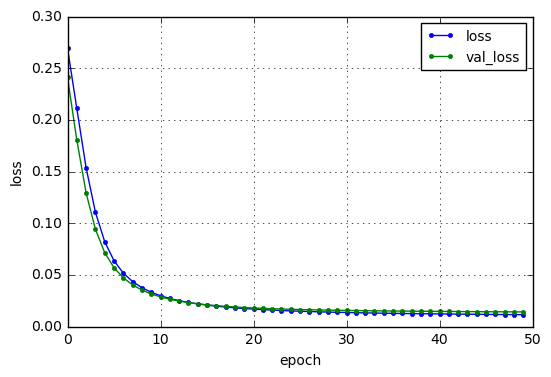

hiden node = 8
_AEdim=008_Win=0512_Sld=0064_sgd_Sparse
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.2786 - val_loss: 0.2669
Epoch 2/50
0s - loss: 0.2507 - val_loss: 0.2328
Epoch 3/50
0s - loss: 0.2132 - val_loss: 0.1933
Epoch 4/50
0s - loss: 0.1748 - val_loss: 0.1572
Epoch 5/50
0s - loss: 0.1423 - val_loss: 0.1284
Epoch 6/50
0s - loss: 0.1169 - val_loss: 0.1063
Epoch 7/50
0s - loss: 0.0976 - val_loss: 0.0896
Epoch 8/50
0s - loss: 0.0830 - val_loss: 0.0769
Epoch 9/50
0s - loss: 0.0718 - val_loss: 0.0671
Epoch 10/50
0s - loss: 0.0631 - val_loss: 0.0594
Epoch 11/50
0s - loss: 0.0561 - val_loss: 0.0531
Epoch 12/50
0s - loss: 0.0504 - val_loss: 0.0479
Epoch 13/50
0s - loss: 0.0456 - val_loss: 0.0437
Epoch 14/50
0s - loss: 0.0417 - val_loss: 0.0401
Epoch 15/50
0s - loss: 0.0383 - val_loss: 0.0371
Epoch 16/50
0s - loss: 0.0355 - val_loss: 0.0345
Epoch 17/50
0s - loss: 0.0330 - val_loss: 0.0323
Epoch 18/50
0s - loss: 0.0309 - val_loss: 0.0305
Epoch 19/50
0s - loss:

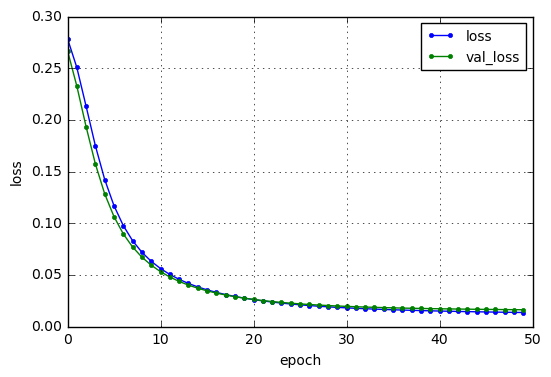

this data had finished making
hiden node = 128
_AEdim=128_Win=1024_Sld=0128_sgd_Sparse
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2683 - val_loss: 0.2288
Epoch 2/50
0s - loss: 0.1979 - val_loss: 0.1669
Epoch 3/50
0s - loss: 0.1388 - val_loss: 0.1128
Epoch 4/50
0s - loss: 0.0929 - val_loss: 0.0755
Epoch 5/50
0s - loss: 0.0635 - val_loss: 0.0534
Epoch 6/50
0s - loss: 0.0466 - val_loss: 0.0410
Epoch 7/50
0s - loss: 0.0373 - val_loss: 0.0342
Epoch 8/50
0s - loss: 0.0321 - val_loss: 0.0303
Epoch 9/50
0s - loss: 0.0290 - val_loss: 0.0279
Epoch 10/50
0s - loss: 0.0270 - val_loss: 0.0262
Epoch 11/50
0s - loss: 0.0255 - val_loss: 0.0250
Epoch 12/50
0s - loss: 0.0244 - val_loss: 0.0240
Epoch 13/50
0s - loss: 0.0235 - val_loss: 0.0231
Epoch 14/50
0s - loss: 0.0227 - val_loss: 0.0224
Epoch 15/50
0s - loss: 0.0220 - val_loss: 0.0218
Epoch 16/50
0s - loss: 0.0215 - val_loss: 0.0213
Epoch 17/50
0s - loss: 0.0210 - val_loss: 0.0209
Epoch 18/50
0s - loss: 0.0206 - val_loss:

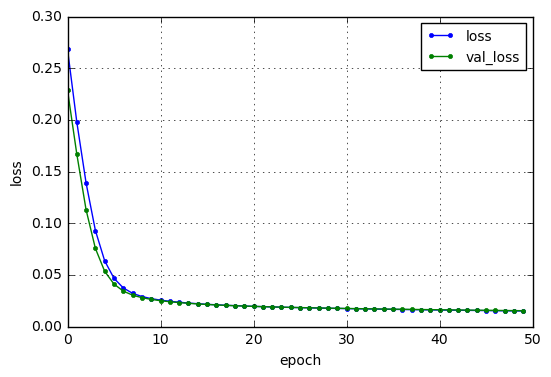

hiden node = 64
_AEdim=064_Win=1024_Sld=0128_sgd_Sparse
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2701 - val_loss: 0.2489
Epoch 2/50
0s - loss: 0.2303 - val_loss: 0.2105
Epoch 3/50
0s - loss: 0.1898 - val_loss: 0.1689
Epoch 4/50
0s - loss: 0.1497 - val_loss: 0.1313
Epoch 5/50
0s - loss: 0.1158 - val_loss: 0.1014
Epoch 6/50
0s - loss: 0.0899 - val_loss: 0.0795
Epoch 7/50
0s - loss: 0.0714 - val_loss: 0.0641
Epoch 8/50
0s - loss: 0.0585 - val_loss: 0.0535
Epoch 9/50
0s - loss: 0.0496 - val_loss: 0.0461
Epoch 10/50
0s - loss: 0.0434 - val_loss: 0.0409
Epoch 11/50
0s - loss: 0.0390 - val_loss: 0.0372
Epoch 12/50
0s - loss: 0.0357 - val_loss: 0.0343
Epoch 13/50
0s - loss: 0.0331 - val_loss: 0.0321
Epoch 14/50
0s - loss: 0.0311 - val_loss: 0.0302
Epoch 15/50
0s - loss: 0.0294 - val_loss: 0.0288
Epoch 16/50
0s - loss: 0.0281 - val_loss: 0.0275
Epoch 17/50
0s - loss: 0.0269 - val_loss: 0.0265
Epoch 18/50
0s - loss: 0.0259 - val_loss: 0.0256
Epoch 19/50
0s - loss: 

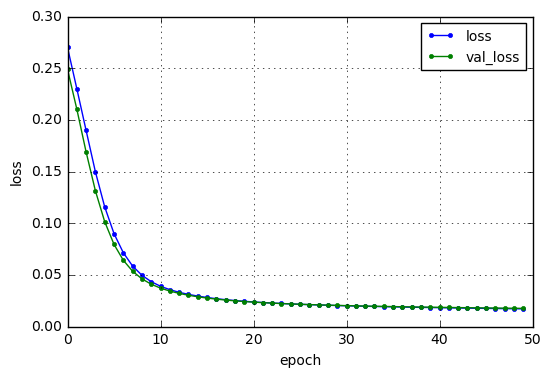

hiden node = 32
_AEdim=032_Win=1024_Sld=0128_sgd_Sparse
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2852 - val_loss: 0.2714
Epoch 2/50
0s - loss: 0.2608 - val_loss: 0.2492
Epoch 3/50
0s - loss: 0.2358 - val_loss: 0.2216
Epoch 4/50
0s - loss: 0.2070 - val_loss: 0.1925
Epoch 5/50
0s - loss: 0.1787 - val_loss: 0.1652
Epoch 6/50
0s - loss: 0.1529 - val_loss: 0.1411
Epoch 7/50
0s - loss: 0.1307 - val_loss: 0.1208
Epoch 8/50
0s - loss: 0.1122 - val_loss: 0.1040
Epoch 9/50
0s - loss: 0.0970 - val_loss: 0.0904
Epoch 10/50
0s - loss: 0.0848 - val_loss: 0.0794
Epoch 11/50
0s - loss: 0.0749 - val_loss: 0.0707
Epoch 12/50
0s - loss: 0.0670 - val_loss: 0.0636
Epoch 13/50
0s - loss: 0.0607 - val_loss: 0.0579
Epoch 14/50
0s - loss: 0.0555 - val_loss: 0.0532
Epoch 15/50
0s - loss: 0.0512 - val_loss: 0.0492
Epoch 16/50
0s - loss: 0.0476 - val_loss: 0.0459
Epoch 17/50
0s - loss: 0.0445 - val_loss: 0.0431
Epoch 18/50
0s - loss: 0.0419 - val_loss: 0.0407
Epoch 19/50
0s - loss: 

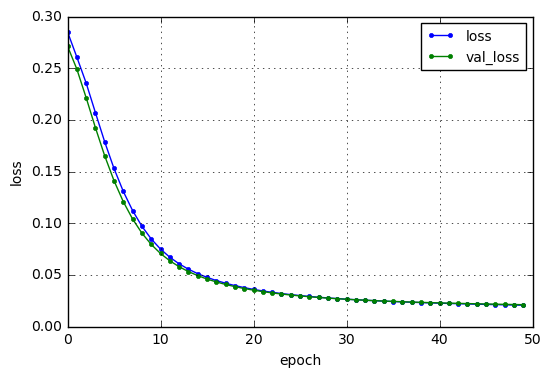

hiden node = 16
_AEdim=016_Win=1024_Sld=0128_sgd_Sparse
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2866 - val_loss: 0.2824
Epoch 2/50
0s - loss: 0.2782 - val_loss: 0.2734
Epoch 3/50
0s - loss: 0.2672 - val_loss: 0.2603
Epoch 4/50
0s - loss: 0.2522 - val_loss: 0.2437
Epoch 5/50
0s - loss: 0.2346 - val_loss: 0.2252
Epoch 6/50
0s - loss: 0.2158 - val_loss: 0.2064
Epoch 7/50
0s - loss: 0.1972 - val_loss: 0.1881
Epoch 8/50
0s - loss: 0.1795 - val_loss: 0.1710
Epoch 9/50
0s - loss: 0.1632 - val_loss: 0.1555
Epoch 10/50
0s - loss: 0.1485 - val_loss: 0.1417
Epoch 11/50
0s - loss: 0.1355 - val_loss: 0.1295
Epoch 12/50
0s - loss: 0.1241 - val_loss: 0.1188
Epoch 13/50
0s - loss: 0.1140 - val_loss: 0.1094
Epoch 14/50
0s - loss: 0.1052 - val_loss: 0.1012
Epoch 15/50
0s - loss: 0.0975 - val_loss: 0.0939
Epoch 16/50
0s - loss: 0.0907 - val_loss: 0.0876
Epoch 17/50
0s - loss: 0.0848 - val_loss: 0.0820
Epoch 18/50
0s - loss: 0.0795 - val_loss: 0.0771
Epoch 19/50
0s - loss: 

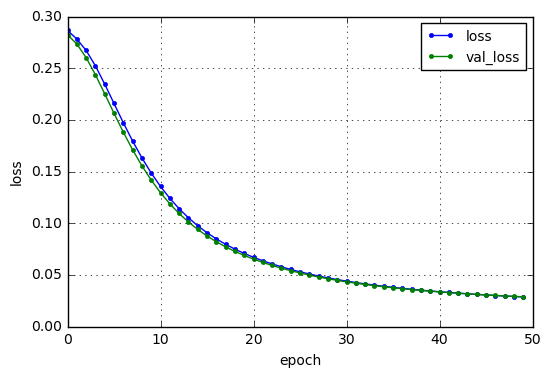

this data had finished making
hiden node = 256
_AEdim=256_Win=2048_Sld=0256_sgd_Sparse
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2947 - val_loss: 0.2655
Epoch 2/50
0s - loss: 0.2470 - val_loss: 0.2299
Epoch 3/50
0s - loss: 0.2150 - val_loss: 0.2000
Epoch 4/50
0s - loss: 0.1857 - val_loss: 0.1714
Epoch 5/50
0s - loss: 0.1580 - val_loss: 0.1448
Epoch 6/50
0s - loss: 0.1330 - val_loss: 0.1215
Epoch 7/50
0s - loss: 0.1115 - val_loss: 0.1019
Epoch 8/50
0s - loss: 0.0938 - val_loss: 0.0862
Epoch 9/50
0s - loss: 0.0798 - val_loss: 0.0738
Epoch 10/50
0s - loss: 0.0689 - val_loss: 0.0643
Epoch 11/50
0s - loss: 0.0606 - val_loss: 0.0571
Epoch 12/50
0s - loss: 0.0543 - val_loss: 0.0517
Epoch 13/50
0s - loss: 0.0496 - val_loss: 0.0476
Epoch 14/50
0s - loss: 0.0460 - val_loss: 0.0444
Epoch 15/50
0s - loss: 0.0432 - val_loss: 0.0420
Epoch 16/50
0s - loss: 0.0411 - val_loss: 0.0401
Epoch 17/50
0s - loss: 0.0394 - val_loss: 0.0386
Epoch 18/50
0s - loss: 0.0380 - val_loss:

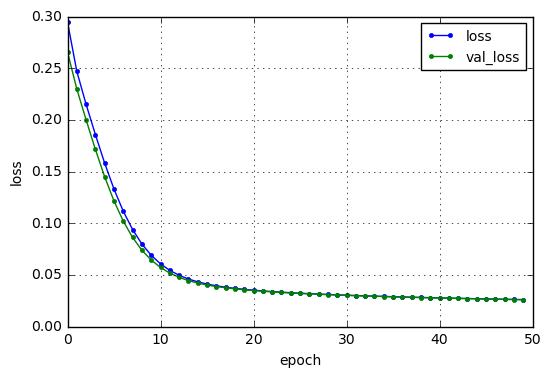

hiden node = 128
_AEdim=128_Win=2048_Sld=0256_sgd_Sparse
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2941 - val_loss: 0.2760
Epoch 2/50
0s - loss: 0.2648 - val_loss: 0.2544
Epoch 3/50
0s - loss: 0.2448 - val_loss: 0.2350
Epoch 4/50
0s - loss: 0.2251 - val_loss: 0.2148
Epoch 5/50
0s - loss: 0.2047 - val_loss: 0.1944
Epoch 6/50
0s - loss: 0.1844 - val_loss: 0.1744
Epoch 7/50
0s - loss: 0.1650 - val_loss: 0.1557
Epoch 8/50
0s - loss: 0.1471 - val_loss: 0.1387
Epoch 9/50
0s - loss: 0.1311 - val_loss: 0.1236
Epoch 10/50
0s - loss: 0.1170 - val_loss: 0.1105
Epoch 11/50
0s - loss: 0.1048 - val_loss: 0.0992
Epoch 12/50
0s - loss: 0.0943 - val_loss: 0.0896
Epoch 13/50
0s - loss: 0.0855 - val_loss: 0.0815
Epoch 14/50
0s - loss: 0.0781 - val_loss: 0.0747
Epoch 15/50
0s - loss: 0.0718 - val_loss: 0.0690
Epoch 16/50
0s - loss: 0.0666 - val_loss: 0.0643
Epoch 17/50
0s - loss: 0.0622 - val_loss: 0.0602
Epoch 18/50
0s - loss: 0.0585 - val_loss: 0.0569
Epoch 19/50
0s - loss:

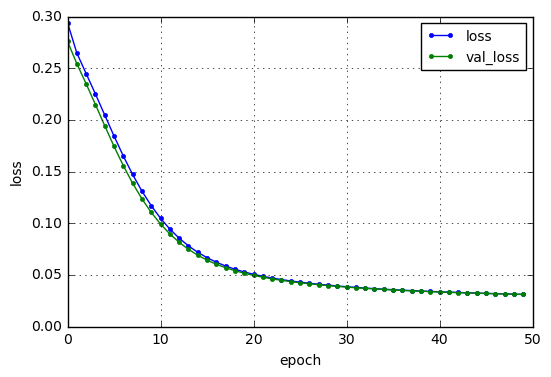

hiden node = 64
_AEdim=064_Win=2048_Sld=0256_sgd_Sparse
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2958 - val_loss: 0.2860
Epoch 2/50
0s - loss: 0.2793 - val_loss: 0.2729
Epoch 3/50
0s - loss: 0.2669 - val_loss: 0.2608
Epoch 4/50
0s - loss: 0.2548 - val_loss: 0.2484
Epoch 5/50
0s - loss: 0.2419 - val_loss: 0.2351
Epoch 6/50
0s - loss: 0.2282 - val_loss: 0.2212
Epoch 7/50
0s - loss: 0.2142 - val_loss: 0.2072
Epoch 8/50
0s - loss: 0.2003 - val_loss: 0.1934
Epoch 9/50
0s - loss: 0.1868 - val_loss: 0.1801
Epoch 10/50
0s - loss: 0.1739 - val_loss: 0.1676
Epoch 11/50
0s - loss: 0.1618 - val_loss: 0.1559
Epoch 12/50
0s - loss: 0.1505 - val_loss: 0.1451
Epoch 13/50
0s - loss: 0.1401 - val_loss: 0.1352
Epoch 14/50
0s - loss: 0.1307 - val_loss: 0.1261
Epoch 15/50
0s - loss: 0.1220 - val_loss: 0.1179
Epoch 16/50
0s - loss: 0.1142 - val_loss: 0.1105
Epoch 17/50
0s - loss: 0.1071 - val_loss: 0.1038
Epoch 18/50
0s - loss: 0.1007 - val_loss: 0.0977
Epoch 19/50
0s - loss: 

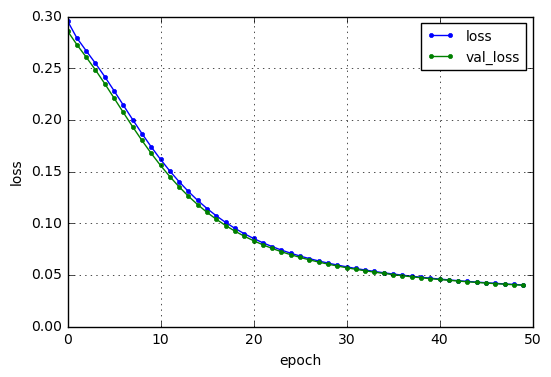

hiden node = 32
_AEdim=032_Win=2048_Sld=0256_sgd_Sparse
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2924 - val_loss: 0.2878
Epoch 2/50
0s - loss: 0.2848 - val_loss: 0.2821
Epoch 3/50
0s - loss: 0.2797 - val_loss: 0.2773
Epoch 4/50
0s - loss: 0.2746 - val_loss: 0.2718
Epoch 5/50
0s - loss: 0.2688 - val_loss: 0.2655
Epoch 6/50
0s - loss: 0.2620 - val_loss: 0.2582
Epoch 7/50
0s - loss: 0.2543 - val_loss: 0.2502
Epoch 8/50
0s - loss: 0.2460 - val_loss: 0.2416
Epoch 9/50
0s - loss: 0.2372 - val_loss: 0.2327
Epoch 10/50
0s - loss: 0.2282 - val_loss: 0.2237
Epoch 11/50
0s - loss: 0.2192 - val_loss: 0.2146
Epoch 12/50
0s - loss: 0.2102 - val_loss: 0.2058
Epoch 13/50
0s - loss: 0.2014 - val_loss: 0.1971
Epoch 14/50
0s - loss: 0.1929 - val_loss: 0.1887
Epoch 15/50
0s - loss: 0.1846 - val_loss: 0.1806
Epoch 16/50
0s - loss: 0.1767 - val_loss: 0.1728
Epoch 17/50
0s - loss: 0.1692 - val_loss: 0.1655
Epoch 18/50
0s - loss: 0.1620 - val_loss: 0.1585
Epoch 19/50
0s - loss: 

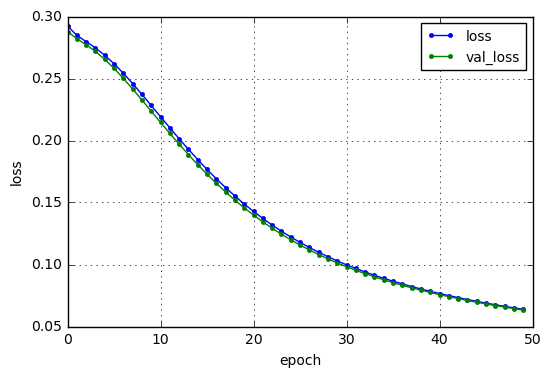

this data had finished making
hiden node = 512
_AEdim=512_Win=4096_Sld=0512_sgd_Sparse
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.3248 - val_loss: 0.3043
Epoch 2/50
0s - loss: 0.2903 - val_loss: 0.2775
Epoch 3/50
0s - loss: 0.2680 - val_loss: 0.2586
Epoch 4/50
0s - loss: 0.2507 - val_loss: 0.2426
Epoch 5/50
0s - loss: 0.2354 - val_loss: 0.2279
Epoch 6/50
0s - loss: 0.2209 - val_loss: 0.2136
Epoch 7/50
0s - loss: 0.2069 - val_loss: 0.1998
Epoch 8/50
0s - loss: 0.1932 - val_loss: 0.1862
Epoch 9/50
0s - loss: 0.1798 - val_loss: 0.1731
Epoch 10/50
0s - loss: 0.1670 - val_loss: 0.1606
Epoch 11/50
0s - loss: 0.1548 - val_loss: 0.1488
Epoch 12/50
0s - loss: 0.1434 - val_loss: 0.1377
Epoch 13/50
0s - loss: 0.1327 - val_loss: 0.1276
Epoch 14/50
0s - loss: 0.1230 - val_loss: 0.1183
Epoch 15/50
0s - loss: 0.1141 - val_loss: 0.1099
Epoch 16/50
0s - loss: 0.1062 - val_loss: 0.1024
Epoch 17/50
0s - loss: 0.0991 - val_loss: 0.0957
Epoch 18/50
0s - loss: 0.0927 - val_loss:

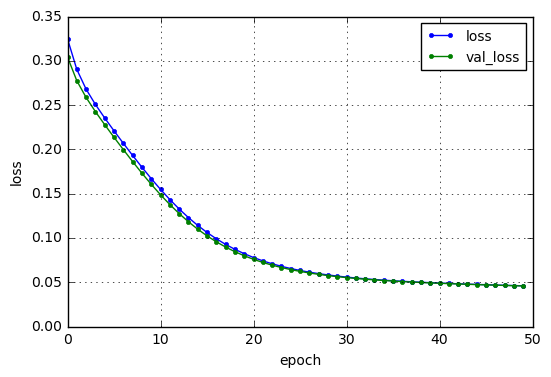

hiden node = 256
_AEdim=256_Win=4096_Sld=0512_sgd_Sparse
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.3043 - val_loss: 0.2950
Epoch 2/50
0s - loss: 0.2885 - val_loss: 0.2825
Epoch 3/50
0s - loss: 0.2778 - val_loss: 0.2731
Epoch 4/50
0s - loss: 0.2691 - val_loss: 0.2649
Epoch 5/50
0s - loss: 0.2610 - val_loss: 0.2569
Epoch 6/50
0s - loss: 0.2530 - val_loss: 0.2488
Epoch 7/50
0s - loss: 0.2447 - val_loss: 0.2403
Epoch 8/50
0s - loss: 0.2361 - val_loss: 0.2316
Epoch 9/50
0s - loss: 0.2273 - val_loss: 0.2226
Epoch 10/50
0s - loss: 0.2182 - val_loss: 0.2135
Epoch 11/50
0s - loss: 0.2090 - val_loss: 0.2042
Epoch 12/50
0s - loss: 0.1997 - val_loss: 0.1949
Epoch 13/50
0s - loss: 0.1905 - val_loss: 0.1857
Epoch 14/50
0s - loss: 0.1814 - val_loss: 0.1768
Epoch 15/50
0s - loss: 0.1725 - val_loss: 0.1680
Epoch 16/50
0s - loss: 0.1639 - val_loss: 0.1596
Epoch 17/50
0s - loss: 0.1557 - val_loss: 0.1516
Epoch 18/50
0s - loss: 0.1479 - val_loss: 0.1440
Epoch 19/50
0s - loss:

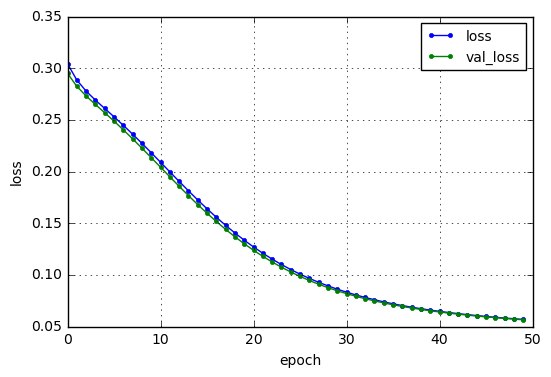

hiden node = 128
_AEdim=128_Win=4096_Sld=0512_sgd_Sparse
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.2980 - val_loss: 0.2926
Epoch 2/50
0s - loss: 0.2890 - val_loss: 0.2855
Epoch 3/50
0s - loss: 0.2829 - val_loss: 0.2804
Epoch 4/50
0s - loss: 0.2782 - val_loss: 0.2760
Epoch 5/50
0s - loss: 0.2740 - val_loss: 0.2718
Epoch 6/50
0s - loss: 0.2697 - val_loss: 0.2675
Epoch 7/50
0s - loss: 0.2653 - val_loss: 0.2628
Epoch 8/50
0s - loss: 0.2605 - val_loss: 0.2579
Epoch 9/50
0s - loss: 0.2553 - val_loss: 0.2526
Epoch 10/50
0s - loss: 0.2499 - val_loss: 0.2470
Epoch 11/50
0s - loss: 0.2441 - val_loss: 0.2411
Epoch 12/50
0s - loss: 0.2381 - val_loss: 0.2350
Epoch 13/50
0s - loss: 0.2320 - val_loss: 0.2288
Epoch 14/50
0s - loss: 0.2257 - val_loss: 0.2224
Epoch 15/50
0s - loss: 0.2193 - val_loss: 0.2160
Epoch 16/50
0s - loss: 0.2129 - val_loss: 0.2096
Epoch 17/50
0s - loss: 0.2065 - val_loss: 0.2032
Epoch 18/50
0s - loss: 0.2002 - val_loss: 0.1969
Epoch 19/50
0s - loss:

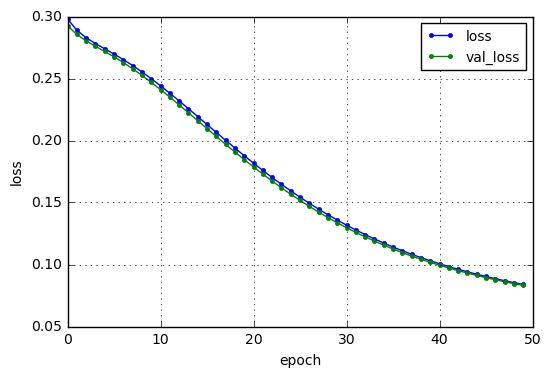

hiden node = 64
_AEdim=064_Win=4096_Sld=0512_sgd_Sparse
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.2922 - val_loss: 0.2895
Epoch 2/50
0s - loss: 0.2877 - val_loss: 0.2860
Epoch 3/50
0s - loss: 0.2847 - val_loss: 0.2834
Epoch 4/50
0s - loss: 0.2823 - val_loss: 0.2812
Epoch 5/50
0s - loss: 0.2802 - val_loss: 0.2790
Epoch 6/50
0s - loss: 0.2779 - val_loss: 0.2768
Epoch 7/50
0s - loss: 0.2756 - val_loss: 0.2743
Epoch 8/50
0s - loss: 0.2730 - val_loss: 0.2716
Epoch 9/50
0s - loss: 0.2702 - val_loss: 0.2686
Epoch 10/50
0s - loss: 0.2671 - val_loss: 0.2655
Epoch 11/50
0s - loss: 0.2639 - val_loss: 0.2621
Epoch 12/50
0s - loss: 0.2604 - val_loss: 0.2586
Epoch 13/50
0s - loss: 0.2568 - val_loss: 0.2549
Epoch 14/50
0s - loss: 0.2530 - val_loss: 0.2510
Epoch 15/50
0s - loss: 0.2491 - val_loss: 0.2471
Epoch 16/50
0s - loss: 0.2451 - val_loss: 0.2430
Epoch 17/50
0s - loss: 0.2410 - val_loss: 0.2388
Epoch 18/50
0s - loss: 0.2368 - val_loss: 0.2346
Epoch 19/50
0s - loss: 

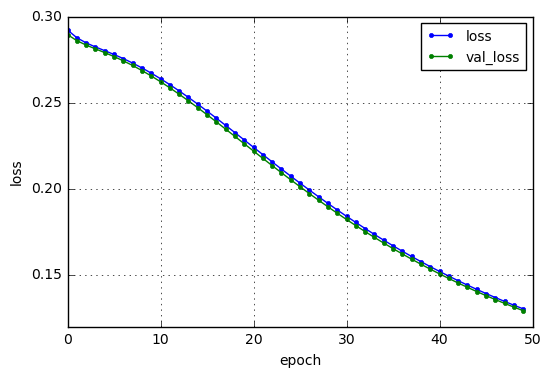

In [42]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
#AEDimention = WindowWidth, WindowWidth/2, WindowWidth/4, WindowWidth/8

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
        
    AEDimentionS=np.array([WindowNum/8,WindowNum/16,WindowNum/32,WindowNum/64])

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)
    
    for AEDimention in AEDimentionS:
        print "hiden node = "+str(AEDimention)
            
        CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
        '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+'_Sparse'
        print CommonName

        SparseAutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

Variational Auto Encoderのサンプルコード

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 0s - loss: 191.0496 - val_loss: 172.7155
Epoch 2/50
60000/60000 [==============================] - 0s - loss: 170.9610 - val_loss: 168.1863
Epoch 3/50
60000/60000 [==============================] - 0s - loss: 167.3244 - val_loss: 165.5549
Epoch 4/50
60000/60000 [==============================] - 0s - loss: 164.9482 - val_loss: 164.0445
Epoch 5/50
60000/60000 [==============================] - 0s - loss: 163.3075 - val_loss: 162.8482
Epoch 6/50
60000/60000 [==============================] - 0s - loss: 162.1148 - val_loss: 161.5311
Epoch 7/50
60000/60000 [==============================] - 0s - loss: 161.0403 - val_loss: 160.6282
Epoch 8/50
60000/60000 [==============================] - 0s - loss: 160.1339 - val_loss: 159.9348
Epoch 9/50
60000/60000 [==============================] - 0s - loss: 159.2259 - val_loss: 158.9045
Epoch 10/50
60000/60000 [==============================] - 

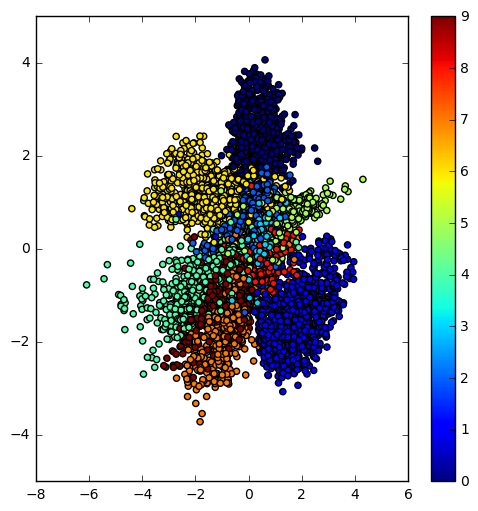

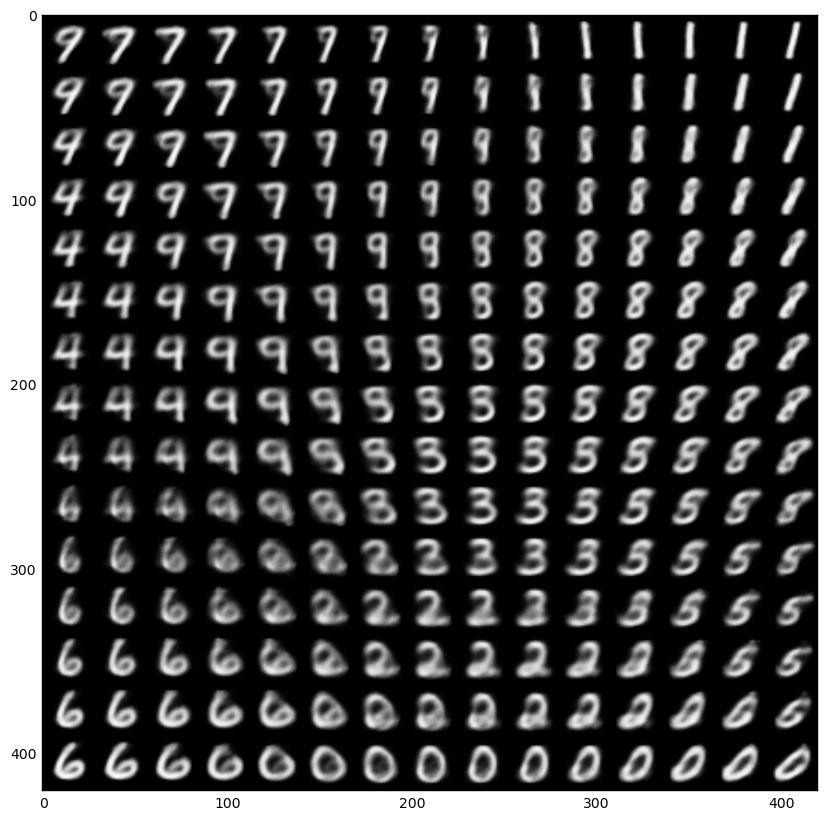

In [43]:
'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 1.0

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [44]:
print 'finish'

finish
